<h1><b>Analysis and forecasting of levels of PM<sub>2.5</sub> fine particulate matter pollution in the air of Chinese cities</b></h1>

<p style="text-align: right;">
    Ivan Aksamentov</br>
    ivan.aksamentov@etu.unistra.fr
</p>

## Introduction

<b>PM<sub>2.5</sub> fine particulate matter</b> is a type of air pollution that consists of dense aerosol particles with diameter less than or equal to 2.5 µm \[1\].

We will be analyzing the levels of PM<sub>2.5</sub> in the air of five large Chinese cities, using one of the available public datasets and common data science packages.

## System setup

First let's import and setup the required packages. At the time of writing we used the following configuration:

In [1]:
import colorsys
import itertools
import math
import os
import platform
import random
import re
import sys
import time
import urllib
from collections import OrderedDict, namedtuple
from functools import reduce
import warnings

import jupyter_client

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pyunpack
import scipy
import seaborn as sns

from notebook import __version__ as nb_ver

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid

import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=3, suppress=True)

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)
pd.set_option('display.html.border', 0)
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('mode.chained_assignment', 'raise')

sns.set()
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = 15.0, 9.0
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.interpolation'] = None
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 1

# Fixed random seed for better reproducibility
SEED=31027409
random.seed(SEED)
np.random.seed(SEED)

versions = pd.DataFrame.from_dict(OrderedDict([
( 'Operating system' , ' '.join(platform.dist()) + ' ' + platform.processor()),
( 'Python' , platform.python_version()),
( 'Jupyter' , jupyter_client.__version__),
( 'Jupyter Notebook' , nb_ver),
( 'Matplotlib' , matplotlib.__version__),
( 'Numpy' , np.__version__),
( 'Pandas' , pd.__version__),
( 'Pyunpac' , pyunpack.__version__),
( 'SciPy' , scipy.__version__),
( 'Seaborn' , sns.__version__),
( 'Scikit-learn' , sklearn.__version__),
( 'Statsmodels' , statsmodels.__version__)
]), orient='index')
versions.columns=['Version']
versions

,Version
Operating system,Ubuntu 16.04 xenial x86_64
Python,3.5.2
Jupyter,5.2.3
Jupyter Notebook,5.6.0
Matplotlib,2.2.2
Numpy,1.14.5
Pandas,0.23.3
Pyunpac,0.1.2
SciPy,1.1.0
Seaborn,0.9.0


Let's also define some of the helper functions and constants that are shared between multiple cells later:

In [31]:
# Time constants
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7
DAYS_IN_YEAR = 365

SEASONS_PALETTE=['#a8a814', '#659324', '#b57d34', '#606d7a']
PRECIPITATION_PALETTE = ['#1db8c6', '#546a7b']

def all_equal(values):
    """
        Checks whether all values in a given list are equal
    """
    return len(list(set(values))) == 1

def dict_to_namedtuple(dictionary):
    """
        Converts a dictionary to a named tuple
    """
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

def namedtuple_to_dict(nt):
    """
        Converts a named tuple to a dictionary
    """
    return nt._asdict()

def highlight_nans(df):
    """
        Highlights invalid values in a given dataframe
    """
    
    return df.style.applymap(
        lambda x: 'color: red' if pd.isna(x) or 'NaN' == x else ''
    )

def highlight_column(columns, predicate=lambda s: s == s.min()):
    """
        Returns a styler for pandas DataFrame, that highlights values
        in some of the columns, according to a provided predicate
    """

    def _highlight_column(s):
        if s.name not in columns:
            return ['' for v in s]

        is_max = predicate(s)
        return ['font-weight: bold; color: #03a733' if v else '' for v in is_max]
    
    return _highlight_column

def add_aqs_daily_baselines(ax):
    """
        Adds daily Chinese Air Quality Standard levels to a given axis of a plot
    """
    
    ax.axhline(AQS_PM25_DAILY_CLASS_1, color='#84e512', label='AQS Daily Class 1')
    ax.axhline(AQS_PM25_DAILY_CLASS_2, color='#e51284', label='AQS Daily Class 2')

def add_aqs_annual_baselines(ax):
    """
        Adds daily Chinese Air Quality Standard levels to a given axis of a plot
    """
    
    ax.axhline(AQS_PM25_ANNUAL_CLASS_1, color='#84e512', label='AQS Annual Class 1')
    ax.axhline(AQS_PM25_ANNUAL_CLASS_2, color='#e51284', label='AQS Annual Class 2')

def prettify_axis(ax):
    """
        Makes a given matplotlib axis a bit prettier
    """
    
    # Remove labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Don't rotate tick labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        
def count_invalid(dataframes):
    """
        Conunts invalid values in a dictionary of dataframes
    """
    
    return pd.DataFrame.from_dict(
        { city: [ df.isna().sum().sum(), len(df)] for city, df in dataframes.items() },
        orient='index'
    ).rename(columns={0: 'Num. NaN', 1: 'Length'})

## Dataset

The dataset we are analyzing is called "PM<sub>2.5</sub> Data of Five Chinese Cities". It can be downloaded from the Machine Learning Repository of the University of California, Irvine \[4\].

Authors request to mention the following publication \[5\] when using the dataset:

    Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), 
    PM2.5 data reliability, consistency, and air quality assessment 
    in five Chinese cities, J. Geophys. Res. Atmos., 121, 
    10,220–10,236, doi: 10.1002/2016JD024877.


Dataset includes information about 5 cities: Beijing, Shanghai, Guangzhou, Chengdu and Shenyang in the form of a multivariate time-series, with time in range from Jan 1st, 2010 to Dec 31st, 2015.

The following attribute information is provided on the dataset page:


| Attribute | Description |
|-----------|-------------|
| No | row number |
| year | year of data in this row |
| month | month of data in this row |
| day | day of data in this row |
| hour | hour of data in this row |
| season | season of data in this row |
| PM | PM<sub>2.5</sub> concentration (µg/m³) |
| DEWP | Dew Point (Celsius Degree) |
| TEMP | Temperature (Celsius Degree) |
| HUMI | Humidity (%) |
| PRES | Pressure (hPa) |
| cbwd | Combined wind direction |
| Iws | Cumulated wind speed (m/s) |
| precipitation | hourly precipitation (mm) |
| Iprec | Cumulated precipitation (mm) |


For every city there are several columns for PM<sub>2.5</sub>. As authors explain in the paper, these values correspond to multiple observational sites within a given city. Weather information was gathered from stations in local airports.

The goal of the research presented in the paper was to asses the reliability of measurements of PM<sub>2.5</sub> and to cross-validate values between different points (in particular, between those belonging to Chinese and to American organizations). 

#### Domain-specific information

There are few important domain specifics we learn from the paper:

 - The cities selected are densely populated industrial centers of China (producing more than 50% of total GDP)
 - The primary source of energy in China is coal. This leads to high air pollution.
 - Weather conditions may affect PM<sub>2.5</sub> concentrations
 
Additionally, in order to better understand and be able to interpret the values of PM<sub>2.5</sub> in the dataset, let's briefly explore the official air pollution regulations available on the web.

According to website TransportPolicy.net, which cites an official document in Chinese language, Chinese Air Quality Standards (AQS) for PM<sub>2.5</sub> pollution are set to the following values (in µg/m³) \[2\]:

|   Averaging | Class 1       | Class 2       |
|-------------|--------------:|--------------:|
|   Annual    | 15            | 35            |
|   Daily     | 35            | 75            |

Although the credibility of the source is up to verification, these numbers look plausible: after comparison with oficial sources for other countries, we note that the US federal documents \[1\] define values that match the values of Class 1 provided above and numbers defined in EU regulations are somewhere in between Class 1 and 2 \[3\].


We will be useing the AQS values described later on, so let's define the variables for them:

In [3]:
# Air Quality Standard
AQS_PM25_DAILY_CLASS_1 = 35
AQS_PM25_DAILY_CLASS_2 = 75
AQS_PM25_ANNUAL_CLASS_1 = 15
AQS_PM25_ANNUAL_CLASS_2 = 35
AQS_DAILY_CLASS_NAMES = ['AQS daily Class 1', 'AQS daily Class 2']
AQS_ANNUAL_CLASS_NAMES = ['AQS annual Class 1', 'AQS annual Class 2']

## Initial examination

Let's download the RAR archive provided and look what's inside:

In [4]:
DATA_DIR=os.path.abspath('data')
TMP_DIR=os.path.abspath('tmp')
URL='https://archive.ics.uci.edu/ml/machine-learning-databases/00394/FiveCitiePMData.rar'
ARCHIVE=os.path.abspath(os.path.join(TMP_DIR, 'FiveCitiePMData.rar'))

# Download archive if not exists
os.makedirs(TMP_DIR, exist_ok=True)
if not os.path.isfile(ARCHIVE): urllib.request.urlretrieve(URL, ARCHIVE)

# Unpack to data dir
os.makedirs(DATA_DIR, exist_ok=True)
pyunpack.Archive(ARCHIVE).extractall(DATA_DIR)

# Print filenames with sizes
filenames = os.listdir(DATA_DIR)
for filename in filenames: print(os.path.getsize(os.path.join(DATA_DIR, filename)), filename)

3040703 ShenyangPM20100101_20151231.csv
3005479 ChengduPM20100101_20151231.csv
3173618 BeijingPM20100101_20151231.csv
3351419 GuangzhouPM20100101_20151231.csv
3044776 ShanghaiPM20100101_20151231.csv


There are 5 files, roughly 3Mb each, one for 5 cities, as advertised.

Next, we will load the data, squash date/time-related columns into a single one, reindex on it, remove redundant columns, make column names more descriptive, and ensure that all 5 time-series correspond to the same temporal range.

In [5]:
def prettify_pm(df): 
    """
        Prettifies "PM" columns of a given dataframe by removing underscores
    """
    df.columns = df.columns.str.replace("_", " ")
    return df

# Map dataframes to corresp. city names
dfs = {
    filename.split('PM')[0]:
       
    prettify_pm(
        # Read CSV files, converting columns 'year', 'month', 'day', 'hour' 
        # into 'Date' column, reindex on 'Date'
        
        pd.read_csv(
            os.path.join(DATA_DIR, filename), 
            parse_dates={'Date': ['year', 'month', 'day', 'hour']},
            date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'),
            index_col='Date'
        )

        # Remove unnecessary 'No' (row number) column
        .drop(
            columns=['No']
        )

        # Make column names a bit more descriptive
        .rename(columns={
            'season': 'Season',
            'DEWP': 'Dew point',
            'TEMP': 'Temperature',
            'HUMI': 'Humidity',
            'PRES': 'Pressure',
            'cbwd': 'Wind dir',
            'Iws': 'Wind speed',
            'precipitation': 'Precip hourly',
            'Iprec': 'Precip cumul',
        })       
    )
    
    for filename in filenames
}

# Ensure all dataframes are of equal lengths and contain the same range of dates
assert all_equal([len(df) for df in dfs.values()]), 'Time series have different length'
assert all_equal([df.index.min() for df in dfs.values()]), 'Time series have different start dates'
assert all_equal([df.index.max() for df in dfs.values()]), 'Time series have different end dates'

Now, let's look at descriptive statistics, and a subsample of values from an arbitrary time range for e.g. Beijing and Chengdu (in al cases we transpose tables for better space utilization):

#### Descriptive statistics for Beijing:

In [6]:
dfs['Beijing'].info()
dfs['Beijing'].describe().transpose()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 13 columns):
Season             52584 non-null int64
PM Dongsi          25052 non-null float64
PM Dongsihuan      20508 non-null float64
PM Nongzhanguan    24931 non-null float64
PM US Post         50387 non-null float64
Dew point          52579 non-null float64
Humidity           52245 non-null float64
Pressure           52245 non-null float64
Temperature        52579 non-null float64
Wind dir           52579 non-null object
Wind speed         52579 non-null float64
Precip hourly      52100 non-null float64
Precip cumul       52100 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 5.6+ MB


,count,mean,std,min,25%,50%,75%,max
Season,52584.0,2.491,1.117,1.00,1.00,2.00,3.00,4.0
PM Dongsi,25052.0,89.154,87.239,3.00,24.00,64.00,124.00,737.0
PM Dongsihuan,20508.0,92.561,88.027,3.00,28.00,68.00,127.00,672.0
PM Nongzhanguan,24931.0,88.644,88.041,3.00,24.00,62.00,122.00,844.0
PM US Post,50387.0,95.904,91.644,1.00,27.00,69.00,132.00,994.0
Dew point,52579.0,2.075,14.222,-40.00,-10.00,2.00,15.00,28.0
Humidity,52245.0,54.602,25.991,2.00,31.00,55.00,78.00,100.0
Pressure,52245.0,1016.465,10.295,991.00,1008.00,1016.00,1025.00,1046.0
Temperature,52579.0,12.587,12.099,-19.00,2.00,14.00,23.00,42.0
Wind speed,52579.0,23.262,49.282,0.45,1.79,4.92,21.02,585.6


#### Descriptive statistics for Chengdu:

In [7]:
dfs['Chengdu'].info()
dfs['Chengdu'].describe().transpose()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 12 columns):
Season           52584 non-null int64
PM Caotangsi     24420 non-null float64
PM Shahepu       24594 non-null float64
PM US Post       28900 non-null float64
Dew point        52055 non-null float64
Humidity         52049 non-null float64
Pressure         52063 non-null float64
Temperature      52057 non-null float64
Wind dir         52063 non-null object
Wind speed       52051 non-null float64
Precip hourly    49629 non-null float64
Precip cumul     49629 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.2+ MB


,count,mean,std,min,25%,50%,75%,max
Season,52584.0,2.491,1.117,1.00,1.00,2.00,3.00,4.0
PM Caotangsi,24420.0,77.507,60.151,3.00,37.00,60.00,99.00,662.0
PM Shahepu,24594.0,75.556,60.338,1.00,35.00,57.00,97.00,573.0
PM US Post,28900.0,83.408,57.240,1.00,44.00,68.00,105.00,688.0
Dew point,52055.0,12.275,7.532,-16.00,6.00,13.00,19.00,28.0
Humidity,52049.0,73.225,17.819,12.78,61.44,77.01,87.75,100.0
Pressure,52063.0,1014.622,8.111,991.00,1008.00,1014.90,1021.00,1041.0
Temperature,52057.0,17.698,7.844,-3.00,11.00,18.00,24.00,38.0
Wind speed,52051.0,4.348,6.424,0.00,1.00,2.00,5.00,120.0
Precip hourly,49629.0,0.107,1.023,0.00,0.00,0.00,0.00,57.0


#### Subsample for Beijing from Aug 1-5 2015:

In [8]:
highlight_nans(dfs['Beijing']['20150801':'20150805'].transpose())

Date,2015-08-01 00:00:00,2015-08-01 01:00:00,2015-08-01 02:00:00,2015-08-01 03:00:00,2015-08-01 04:00:00,2015-08-01 05:00:00,2015-08-01 06:00:00,2015-08-01 07:00:00,2015-08-01 08:00:00,2015-08-01 09:00:00,2015-08-01 10:00:00,2015-08-01 11:00:00,2015-08-01 12:00:00,2015-08-01 13:00:00,2015-08-01 14:00:00,2015-08-01 15:00:00,2015-08-01 16:00:00,2015-08-01 17:00:00,2015-08-01 18:00:00,2015-08-01 19:00:00,2015-08-01 20:00:00,2015-08-01 21:00:00,2015-08-01 22:00:00,2015-08-01 23:00:00,2015-08-02 00:00:00,2015-08-02 01:00:00,2015-08-02 02:00:00,2015-08-02 03:00:00,2015-08-02 04:00:00,2015-08-02 05:00:00,2015-08-02 06:00:00,2015-08-02 07:00:00,2015-08-02 08:00:00,2015-08-02 09:00:00,2015-08-02 10:00:00,2015-08-02 11:00:00,2015-08-02 12:00:00,2015-08-02 13:00:00,2015-08-02 14:00:00,2015-08-02 15:00:00,2015-08-02 16:00:00,2015-08-02 17:00:00,2015-08-02 18:00:00,2015-08-02 19:00:00,2015-08-02 20:00:00,2015-08-02 21:00:00,2015-08-02 22:00:00,2015-08-02 23:00:00,2015-08-03 00:00:00,2015-08-03 01:00:00,2015-08-03 02:00:00,2015-08-03 03:00:00,2015-08-03 04:00:00,2015-08-03 05:00:00,2015-08-03 06:00:00,2015-08-03 07:00:00,2015-08-03 08:00:00,2015-08-03 09:00:00,2015-08-03 10:00:00,2015-08-03 11:00:00,2015-08-03 12:00:00,2015-08-03 13:00:00,2015-08-03 14:00:00,2015-08-03 15:00:00,2015-08-03 16:00:00,2015-08-03 17:00:00,2015-08-03 18:00:00,2015-08-03 19:00:00,2015-08-03 20:00:00,2015-08-03 21:00:00,2015-08-03 22:00:00,2015-08-03 23:00:00,2015-08-04 00:00:00,2015-08-04 01:00:00,2015-08-04 02:00:00,2015-08-04 03:00:00,2015-08-04 04:00:00,2015-08-04 05:00:00,2015-08-04 06:00:00,2015-08-04 07:00:00,2015-08-04 08:00:00,2015-08-04 09:00:00,2015-08-04 10:00:00,2015-08-04 11:00:00,2015-08-04 12:00:00,2015-08-04 13:00:00,2015-08-04 14:00:00,2015-08-04 15:00:00,2015-08-04 16:00:00,2015-08-04 17:00:00,2015-08-04 18:00:00,2015-08-04 19:00:00,2015-08-04 20:00:00,2015-08-04 21:00:00,2015-08-04 22:00:00,2015-08-04 23:00:00,2015-08-05 00:00:00,2015-08-05 01:00:00,2015-08-05 02:00:00,2015-08-05 03:00:00,2015-08-05 04:00:00,2015-08-05 05:00:00,2015-08-05 06:00:00,2015-08-05 07:00:00,2015-08-05 08:00:00,2015-08-05 09:00:00,2015-08-05 10:00:00,2015-08-05 11:00:00,2015-08-05 12:00:00,2015-08-05 13:00:00,2015-08-05 14:00:00,2015-08-05 15:00:00,2015-08-05 16:00:00,2015-08-05 17:00:00,2015-08-05 18:00:00,2015-08-05 19:00:00,2015-08-05 20:00:00,2015-08-05 21:00:00,2015-08-05 22:00:00,2015-08-05 23:00:00
Season,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
PM Dongsi,59,62,68,71,73,80,80,87,83,89,90,84,85,94,87,66,58,60,68,69,78,87,84,62,53,67,77,79,58,43,49,45,42,57,68,90,99,87,97,93,97,116,102,99,97,90,80,84,85,93,100,105,148,157,157,164,137,101,95,85,86,58,28,23,20,21,19,13,8,16,10,11,10,10,10,17,16,12,16,15,13,13,18,18,22,19,nan,nan,12,15,27,39,37,51,50,64,71,83,85,85,92,88,91,88,102,115,135,145,nan,nan,nan,nan,69,55,70,90,76,48,27,21
PM Dongsihuan,57,73,95,114,106,98,103,108,107,96,89,66,66,67,84,71,50,62,71,92,106,99,94,63,48,55,59,59,40,47,51,49,60,63,80,100,102,86,84,85,87,97,97,92,94,90,74,75,76,85,95,117,127,139,143,134,120,95,100,78,69,56,26,11,14,16,9,11,11,6,10,6,7,7,13,18,16,20,22,10,10,19,17,20,21,20,20,16,15,15,29,36,34,48,55,65,69,73,89,87,86,86,93,101,101,118,132,141,nan,nan,nan,nan,47,52,65,84,82,53,26,22
PM Nongzhanguan,42,46,65,76,69,72,72,79,79,78,72,62,72,76,79,60,44,42,55,64,69,78,80,58,41,46,52,52,36,41,39,42,49,54,67,90,88,88,79,82,86,88,91,79,76,81,61,64,71,71,81,97,115,128,136,137,118,89,90,75,69,53,25,8,10,9,4,3,7,3,3,3,3,3,3,3,3,5,6,6,10,11,12,13,19,18,11,8,10,12,28,36,33,39,41,52,59,65,72,76,81,82,81,78,91,108,120,130,nan,nan,nan,nan,51,44,65,79,71,41,16,14
PM US Post,66,61,80,91,81,87,77,83,76,67,60,59,61,74,78,50,51,61,68,87,95,93,78,55,45,65,64,64,37,47,51,51,54,63,76,82,75,63,65,60,68,76,84,77,86,86,60,70,79,95,93,114,123,131,137,136,98,80,73,65

#### Subsample for Chengdu from Jan 1-5 2012:

In [9]:
highlight_nans(dfs['Chengdu']['20130101':'20130105'].transpose())

Date,2013-01-01 00:00:00,2013-01-01 01:00:00,2013-01-01 02:00:00,2013-01-01 03:00:00,2013-01-01 04:00:00,2013-01-01 05:00:00,2013-01-01 06:00:00,2013-01-01 07:00:00,2013-01-01 08:00:00,2013-01-01 09:00:00,2013-01-01 10:00:00,2013-01-01 11:00:00,2013-01-01 12:00:00,2013-01-01 13:00:00,2013-01-01 14:00:00,2013-01-01 15:00:00,2013-01-01 16:00:00,2013-01-01 17:00:00,2013-01-01 18:00:00,2013-01-01 19:00:00,2013-01-01 20:00:00,2013-01-01 21:00:00,2013-01-01 22:00:00,2013-01-01 23:00:00,2013-01-02 00:00:00,2013-01-02 01:00:00,2013-01-02 02:00:00,2013-01-02 03:00:00,2013-01-02 04:00:00,2013-01-02 05:00:00,2013-01-02 06:00:00,2013-01-02 07:00:00,2013-01-02 08:00:00,2013-01-02 09:00:00,2013-01-02 10:00:00,2013-01-02 11:00:00,2013-01-02 12:00:00,2013-01-02 13:00:00,2013-01-02 14:00:00,2013-01-02 15:00:00,2013-01-02 16:00:00,2013-01-02 17:00:00,2013-01-02 18:00:00,2013-01-02 19:00:00,2013-01-02 20:00:00,2013-01-02 21:00:00,2013-01-02 22:00:00,2013-01-02 23:00:00,2013-01-03 00:00:00,2013-01-03 01:00:00,2013-01-03 02:00:00,2013-01-03 03:00:00,2013-01-03 04:00:00,2013-01-03 05:00:00,2013-01-03 06:00:00,2013-01-03 07:00:00,2013-01-03 08:00:00,2013-01-03 09:00:00,2013-01-03 10:00:00,2013-01-03 11:00:00,2013-01-03 12:00:00,2013-01-03 13:00:00,2013-01-03 14:00:00,2013-01-03 15:00:00,2013-01-03 16:00:00,2013-01-03 17:00:00,2013-01-03 18:00:00,2013-01-03 19:00:00,2013-01-03 20:00:00,2013-01-03 21:00:00,2013-01-03 22:00:00,2013-01-03 23:00:00,2013-01-04 00:00:00,2013-01-04 01:00:00,2013-01-04 02:00:00,2013-01-04 03:00:00,2013-01-04 04:00:00,2013-01-04 05:00:00,2013-01-04 06:00:00,2013-01-04 07:00:00,2013-01-04 08:00:00,2013-01-04 09:00:00,2013-01-04 10:00:00,2013-01-04 11:00:00,2013-01-04 12:00:00,2013-01-04 13:00:00,2013-01-04 14:00:00,2013-01-04 15:00:00,2013-01-04 16:00:00,2013-01-04 17:00:00,2013-01-04 18:00:00,2013-01-04 19:00:00,2013-01-04 20:00:00,2013-01-04 21:00:00,2013-01-04 22:00:00,2013-01-04 23:00:00,2013-01-05 00:00:00,2013-01-05 01:00:00,2013-01-05 02:00:00,2013-01-05 03:00:00,2013-01-05 04:00:00,2013-01-05 05:00:00,2013-01-05 06:00:00,2013-01-05 07:00:00,2013-01-05 08:00:00,2013-01-05 09:00:00,2013-01-05 10:00:00,2013-01-05 11:00:00,2013-01-05 12:00:00,2013-01-05 13:00:00,2013-01-05 14:00:00,2013-01-05 15:00:00,2013-01-05 16:00:00,2013-01-05 17:00:00,2013-01-05 18:00:00,2013-01-05 19:00:00,2013-01-05 20:00:00,2013-01-05 21:00:00,2013-01-05 22:00:00,2013-01-05 23:00:00
Season,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
PM Caotangsi,121,134,nan,203,217,220,214,209,228,219,225,192,nan,159,168,143,113,85,93,117,118,122,158,169,210,nan,182,145,126,109,122,124,124,175,nan,174,208,219,220,155,103,97,79,38,43,nan,51,59,56,52,45,48,49,52,47,50,51,59,65,39,57,51,50,53,57,56,48,53,51,72,77,68,70,74,75,72,74,74,67,79,94,88,84,77,82,89,102,112,106,95,97,88,87,67,68,60,48,46,65,76,75,74,nan,nan,79,nan,77,75,76,75,80,92,99,98,98,96,106,117,131,nan
PM Shahepu,138,159,nan,162,157,170,225,244,242,277,281,284,nan,181,184,162,151,146,147,164,165,171,223,222,194,nan,198,193,188,191,166,148,157,163,nan,237,256,278,276,265,199,169,134,87,76,nan,79,72,77,77,73,66,68,68,58,66,61,64,63,85,74,74,67,77,80,78,79,79,80,74,88,94,92,97,93,100,105,106,108,93,112,115,123,133,145,134,3,34,113,115,104,89,78,78,70,70,68,65,67,67,79,69,nan,nan,90,nan,113,132,130,128,123,98,96,113,113,114,115,108,115,nan
PM US Post,129,135,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,189,132,100,101,91,95,115,129,138,159,163,155,170,193,202,167,148,144,139,180,153,161,185,nan,nan,nan,nan,nan,126,113,56,56,58,67,65,66,70,66,60,55,62,61,62,59,61,68,69,67,67,57,68,70,75,75,72,78,69,94,100,99,89,96,94,100,96,95,101,100,103,118,128,140,149,146,140,158,131,117,100,73,66,64,65,62,58,62,60,80,105,92,58,72,96,103,133,160,135,123,112,117,135,124,115,120,130,135,155,185
Dew point,-4,-3,-3,-3,-1,-3,-2,-2,-3,-2,-

We note large amounts of invalid values for PM<sub>2.5</sub> and we will study that in a moment. 

Another anomaly is the enormous max values for the precipitation in Beijing, compared to Chengdu. There might be mistakes.

### Data cleaning

#### Erroneous values for precipitation

Let's plot precipitation over time to see whether we should discard the unusually high values as invalid. 
We hypothesise that there might have been a flood during these observations.

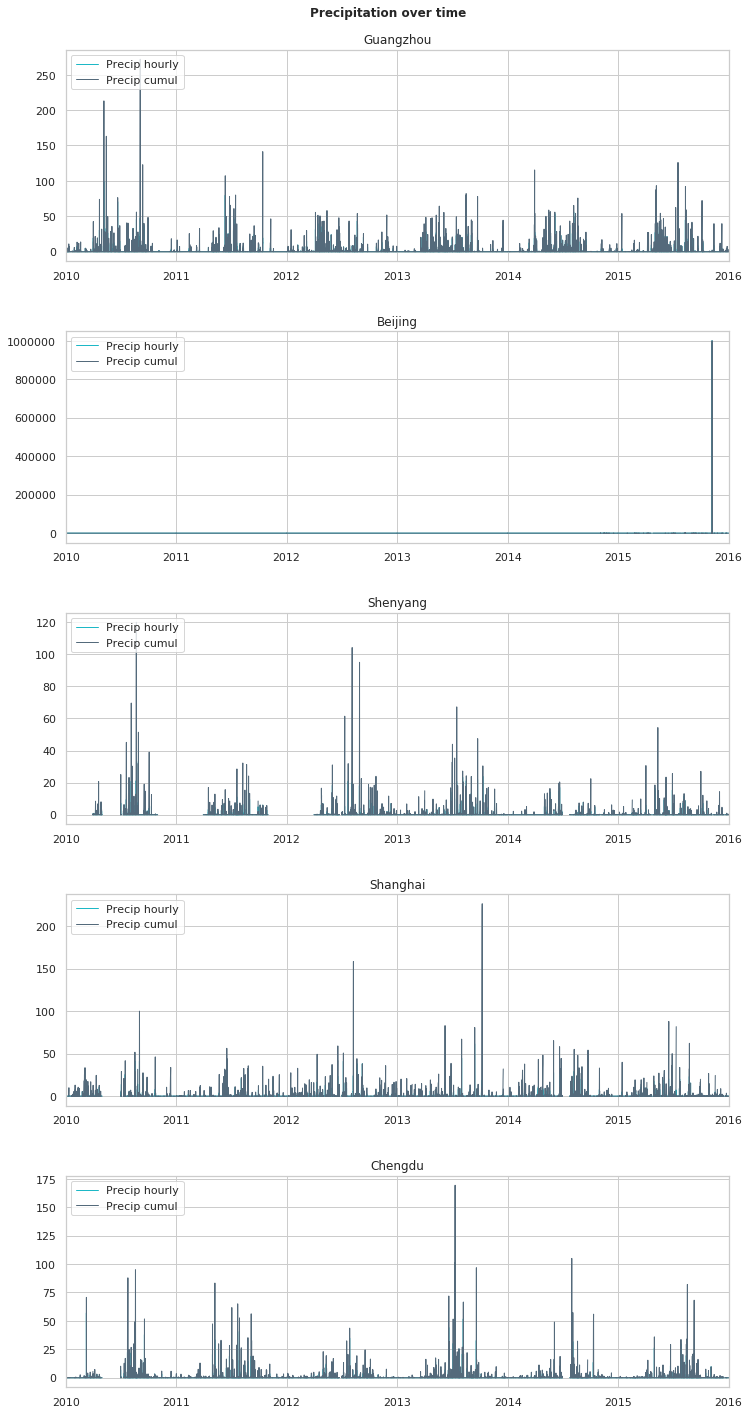

In [10]:
with sns.color_palette(PRECIPITATION_PALETTE):

    fig, ax = plt.subplots(nrows=len(dfs), ncols=1, figsize=(10,len(dfs) * 4))
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, hspace=0.33)
    fig.suptitle('Precipitation over time')

    for i, (city, df) in enumerate(dfs.items()):   
        df = df.filter(like='Precip')
        df.plot(ax=ax[i], title=city, xlim=('2010', '2016'))
        prettify_axis(ax[i])
        ax[i].legend(loc='upper left')

It looks like there is a one-off error in precipitation values and only for for Beijing. Quick search does not reveal any information about floods or precipitation-related disasters in Beijing in 2015. However, Wikipedia reports a flood in 2012 with precipitation levels around 460 mm \[6]. Additionally, values above few hundreds doesn't seem plausible for our planet. Let's discard all unrealistic values, say above 2000.

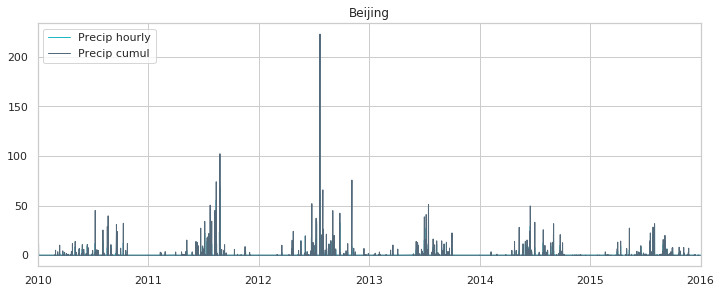

In [11]:
# Discard values above threshold
threshold = 2000
df = dfs['Beijing']
df[(df['Precip hourly'] > threshold) & (df['Precip cumul'] > threshold)] = np.nan
dfs['Beijing'] = df

with sns.color_palette(PRECIPITATION_PALETTE):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, hspace=0.33)

    df.filter(like='Precip').plot(ax=ax, title='Beijing', xlim=('2010', '2016'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(loc='upper left')

    plt.show()
    dfs['Beijing'].describe().transpose()

Looks much better now. And we can indeed observe a sharp spike in precipitation levels during the flood of July 2012.

#### Contiguity of valid samples

Contiguity of observations is very important for succesful analysis and forecasting of time-series, so let's also visualize the distribution of invalid (missing) values over time:

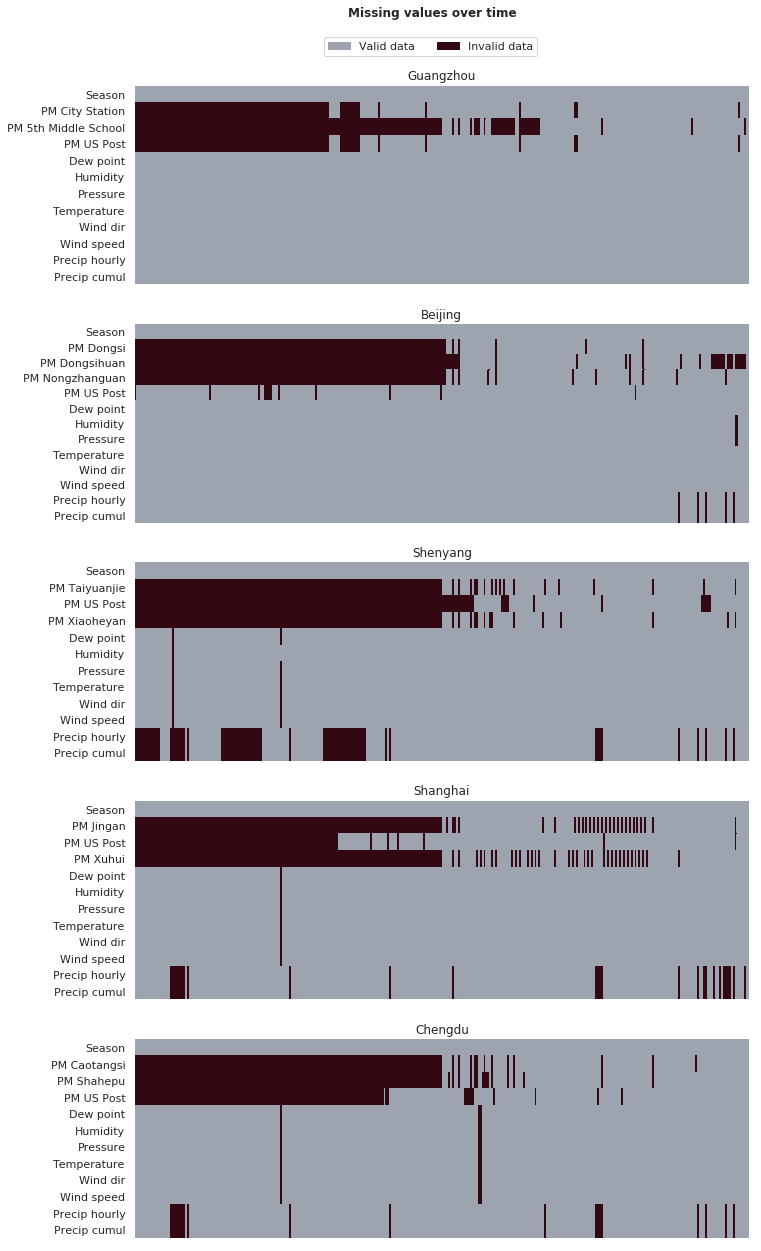

In [12]:
# Plot only once in a week to speed things up
interval = HOURS_IN_DAY * DAYS_IN_WEEK

# Legend entries
cmap=['#320813', '#9ea3b0']
invalid = matplotlib.patches.Patch(color=cmap[0], label='Invalid data')
valid = matplotlib.patches.Patch(color=cmap[1], label='Valid data')

fig, ax = plt.subplots(nrows=len(dfs), ncols=1, figsize=(11,len(dfs) * 4), sharex=True)
fig.legend(handles=[valid, invalid], loc=(0.425,0.955), ncol=2)
fig.suptitle('Missing values over time')
fig.subplots_adjust(top=0.925)

for i, (city, df) in enumerate(dfs.items()):   
    sns.heatmap(df[::interval].notna().transpose(), 
        cbar=False, cmap=cmap, 
        ax=ax[i], xticklabels=False, annot=False)
    ax[i].set_title(city)
    prettify_axis(ax[i])

count_invalid(dfs)
plt.show()

Sadly, for the first half of the dataset, PM<sub>2.5</sub> values are missing almost universally, rendering this part completely unusable. Other collumns have small gaps here and there too, but we probably can deal with it. 

In the next sections we will concentrate on methods that can tolerate invalid values, but later, before trying forecating models, we will need to fill the missing values.

## Stationarity

Let's take a quick look at the behavior of rolling mean and rolling standard deviation of PM<sub>2.5</sub> levels for one city:

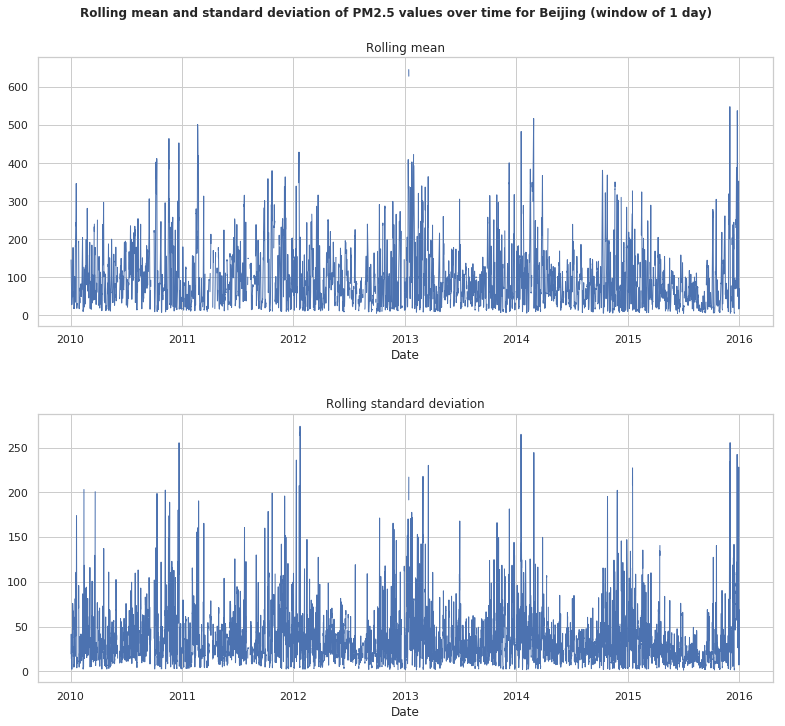

In [13]:
df = dfs['Beijing']['PM US Post']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 10))
plt.tight_layout()
fig.subplots_adjust(top=0.91, hspace=0.33)
fig.suptitle('Rolling mean and standard deviation of PM2.5 values over time for Beijing (window of 1 day)')

window=HOURS_IN_DAY

df.rolling(window).mean().plot(ax=axes[0], title='Rolling mean')
df.rolling(window).std().plot(ax=axes[1], title='Rolling standard deviation');

It is obvious that the PM<sub>2.5</sub> data is not stationary from looking at this plot alone. We will explore the trend and the seasonal decomposition in more details later, after we cleanup the data and fill the gaps.

Now let's compare the data against some simple domain-specific constants.

## Comparison to Air Quality Standards


For a simple assesment of air quality, let's compute the daily and annual average and visualize them against the Air Quality Standards (AQS) we defined before.

#### Daily average

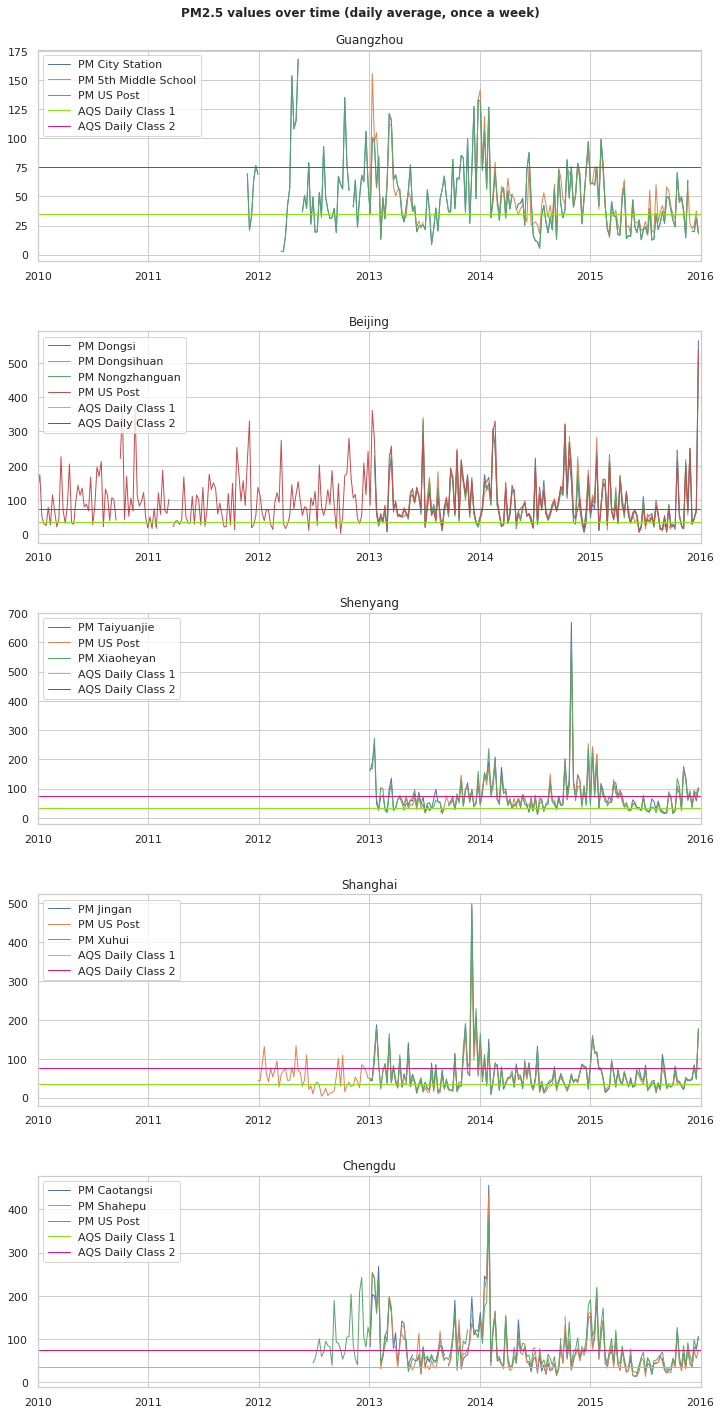

In [14]:
fig, ax = plt.subplots(nrows=len(dfs), ncols=1, figsize=(10,len(dfs) * 4))
plt.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.33)
fig.suptitle('PM2.5 values over time (daily average, once a week)')

for i, (city, df) in enumerate(dfs.items()):   
    df = df.filter(like='PM').resample('D').mean()[::DAYS_IN_WEEK] # average daily, take one every week
    df.plot(ax=ax[i], title=city, xlim=('2010', '2016'))
    add_aqs_daily_baselines(ax[i])   
    prettify_axis(ax[i])
    ax[i].legend(loc='upper left')

#### Annual average

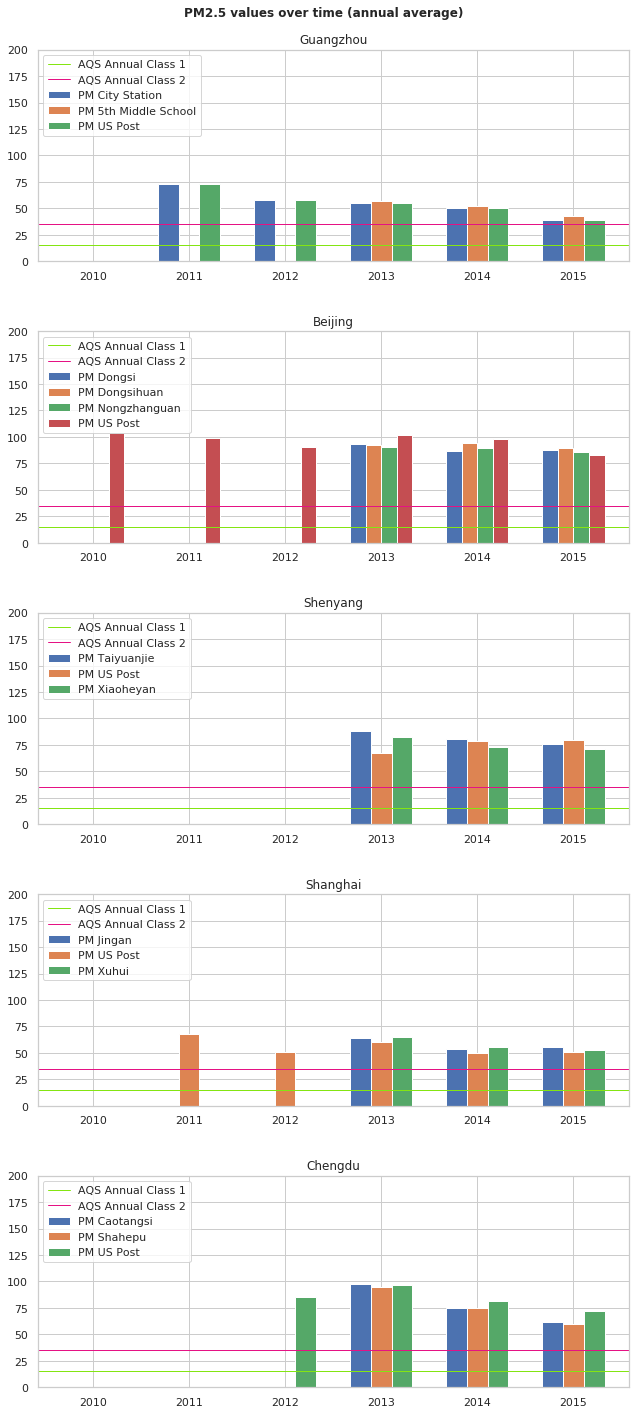

In [15]:
fig, ax = plt.subplots(nrows=len(dfs), ncols=1, figsize=(9,len(dfs) * 4))
plt.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.33)
fig.suptitle('PM2.5 values over time (annual average)')

for i, (city, df) in enumerate(dfs.items()):   
    # Average PM annually
    df = df.filter(like='PM').resample('Y').mean()
    
    # Index by year
    df.index = df.index.year
    
    df.plot(ax=ax[i], kind='bar', title=city, ylim=(0,200), width=0.65)   
    add_aqs_annual_baselines(ax[i])
    ax[i].legend(loc='upper left')
    prettify_axis(ax[i])
        

One can see with the naked eye, that both, daily and annual PM<sub>2.5</sub> values steadily exceed levels defined by AQS. This raises concerns about quality of air and possible negative influence on health of the population of China. 

At first glance, PM<sub>2.5</sub> levels correlate well between observation stations within a given city, without major discrepancies.




## Comparison of PM<sub>2.5</sub> levels in different cities

Let's compare the pollution in different cities. We will take observations from the "US Post" station that is present in every city.

### Daily average for all cities

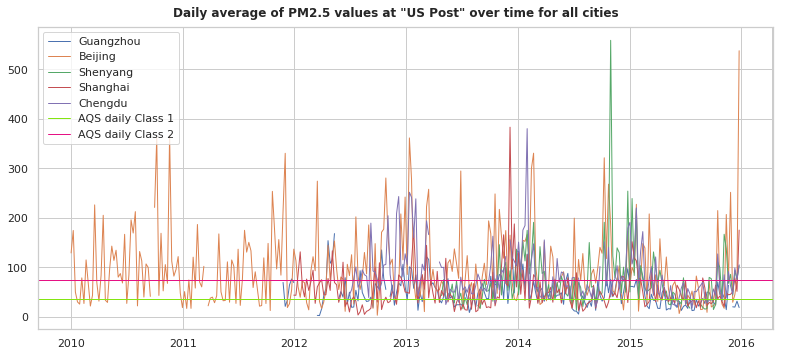

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
plt.tight_layout()
fig.subplots_adjust(top=0.925)
fig.suptitle('Daily average of PM2.5 values at "US Post" over time for all cities')

for city, df in dfs.items():   
    df = df['PM US Post'].resample('D').mean()[::DAYS_IN_WEEK].plot(ax=ax)

add_aqs_daily_baselines(ax)
prettify_axis(ax)
ax.legend(list(dfs.keys()) + AQS_DAILY_CLASS_NAMES, loc='upper left');

### Annual average for all cities

,Guangzhou,Beijing,Shenyang,Shanghai,Chengdu
Date,,,,,
2010,,104,,,
2011,73.1,99.1,,68.1,
2012,57.7,90.5,,50.9,85
2013,55.5,102,67,60,97.1
2014,49.9,97.7,78.3,49.9,81.9
2015,39.4,82.8,79.3,50.7,72.4


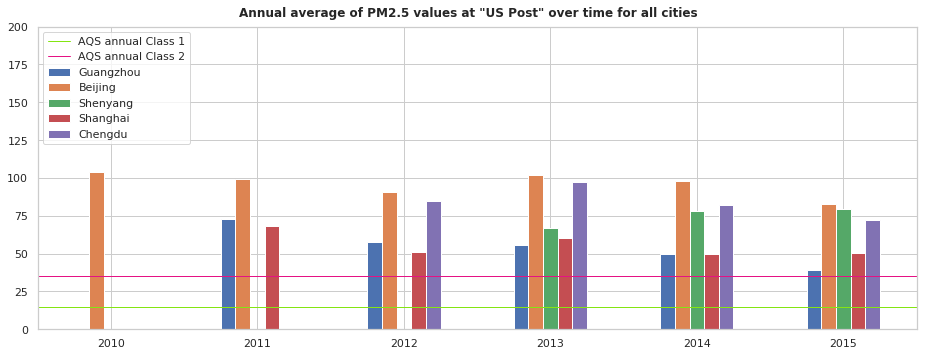

In [17]:
# Merge all cities into one DataFrame
df = [ 
    df.filter(like='PM US Post')
    .rename(columns={'PM US Post': city})
    
    for city, df in dfs.items() 
]
df = reduce(lambda l, r: l.merge(r, on='Date'), df)

# Average per year
df = df.resample('Y').mean()
df.index = df.index.year

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))
plt.tight_layout()
fig.subplots_adjust(top=0.925)
fig.suptitle('Annual average of PM2.5 values at "US Post" over time for all cities')

df.plot(kind='bar', ylim=(0,200), ax=ax)

add_aqs_annual_baselines(ax)

ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(AQS_ANNUAL_CLASS_NAMES + list(dfs.keys()), loc='upper left');
for tick in ax.get_xticklabels(): tick.set_rotation(0)

def round_int(f): 
    return int(round(f))

def rgb_float_to_int(rgbf):
    return round_int(rgbf[0] * 255), round_int(rgbf[1] * 255), round_int(rgbf[2] * 255)

def rgb_float_to_hex(rgbf):
    return '#%02x%02x%02x' % rgb_float_to_int(rgbf)

def color_by_value(lo, hi):
    def _color_by_value(x):
        if pd.isnull(x) or x == "": return ""
        h = (1 - ((x - lo) / (hi - lo))) / 3
        rgbf = colorsys.hsv_to_rgb(h, 0.8, 0.95)
        color_hex = rgb_float_to_hex(rgbf)
        return 'background: {}'.format(color_hex)   
    return _color_by_value

lo = df.min().min()
hi = df.max().max()
df = df.replace(np.nan, '')
df.style.applymap(color_by_value(lo, hi))

It seems that, on average, people in Shanghai and Guangzhou enjoy slightly cleaner air than their compatriots from Beijing, Chengdu and Shenyang. In fact, Guangzhou has almost reached the Class 2 AQS compliance for year 2015 (39 µg/m³, while 35 µg/m³ is required).

Interestingly, daily-averaged plots, reveal visually clear periodicity in pollution levels. We observe elevated values during winter seasons, while during summer pollution levels decrease. We will study this behavior in a moment, but right now, let's take a quick look on correlation between variables in the dataset.


## Correlation analysis

In order to get a rough understanding of how data columns are related to each other, let's calculate Pearson's correlation coefficients for every pair of columns and visualize them as a heatmap:

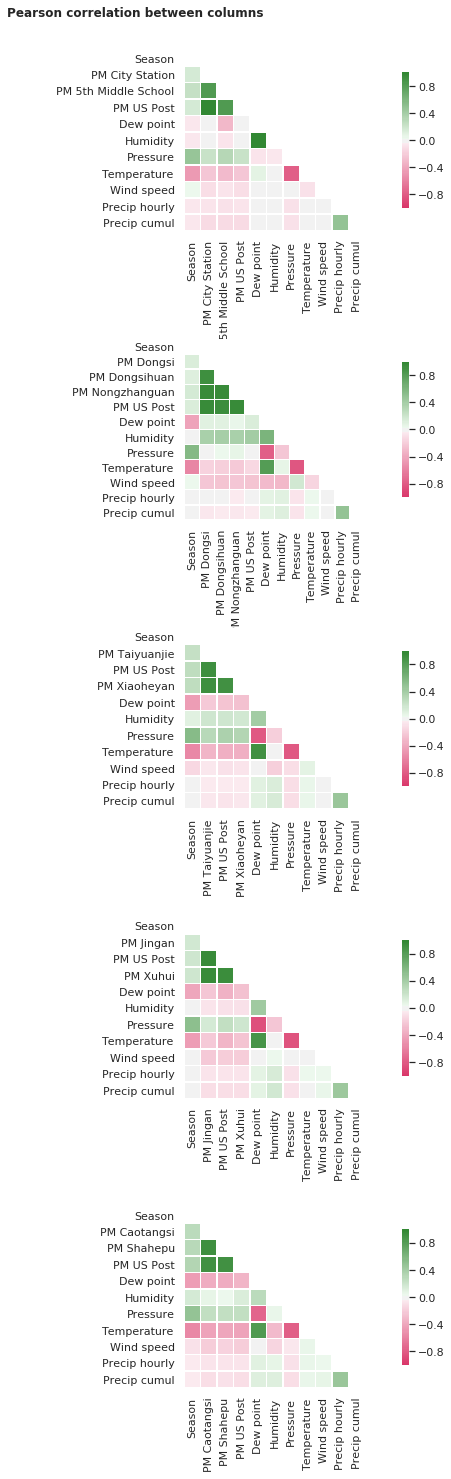

In [18]:
fig, axs = plt.subplots(nrows=len(dfs), ncols=1, figsize=(11,len(dfs) * 4))
plt.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.6)
fig.suptitle('Pearson correlation between columns')

for ax, (city, df) in zip(axs, dfs.items()):   
    corr = df.corr()
    
    # Hide upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Bipolar palette
    cmap = sns.diverging_palette(h_neg=0, h_pos=128, s=80, l=50, n=128)
    
    sns.heatmap(corr, ax=ax, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

Cross-corellating the PM<sub>2.5</sub> levels from different sources was the primary topic in \[5\] (authors investigated potential fraud regarding values provided by Chinese sources, as compared to US sources). Our correlation matrices confirm their findings, showing a good match between values across observational stations within each city, across all Chinese and American stations.

Weather parameters, such as temperature, pressure, dew point etc. obviously correlate well between each other and in relation to seasons (forming the theoretical basis for meteorology and weather forecasting), but studying weather is out of scope of this work, so we will ignore these correlations for now.

For all cities we observe a promising correlation between PM<sub>2.5</sub> and temperature, sometimes accompanied by correlation to pressure, wind speed and season. We will perform a more detailed study of this association in the next few sections.

## Seasonal fluctuations

Let's explore in some more details the periodic behavior of PM<sub>2.5</sub> levels in relation to seasons of the year and temperature.

#### PM<sub>2.5</sub> levels averaged by seasons

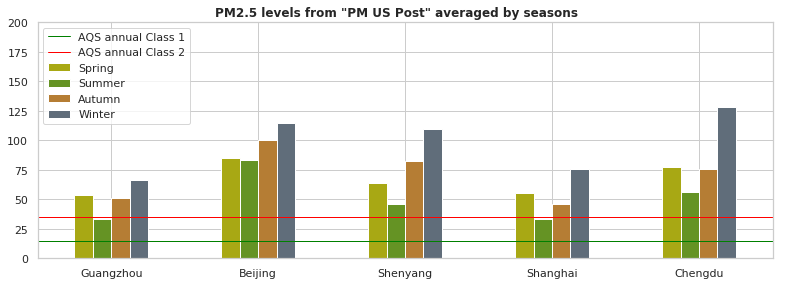

In [19]:
# Merge all cities into one DataFrame
df = [ 
    df[['PM US Post', 'Season']]
    .rename(columns={'PM US Post': city})
    
    for city, df in dfs.items() 
]

# Average by seasons
df = reduce(lambda l, r: l.merge(r, on='Date'), df)\
     .groupby(['Season']) \
     .mean() \
     .filter(regex='^(?!Season)')

df.index = ['Spring', 'Summer', 'Autumn', 'Winter']

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,4))
plt.tight_layout()
fig.subplots_adjust(top=0.925)
fig.suptitle('PM2.5 levels from "PM US Post" averaged by seasons')

with sns.color_palette(SEASONS_PALETTE):
    df.transpose().plot(kind='bar', ylim=(0,200), ax=ax)

# Add AQS baselines
ax.axhline(AQS_PM25_ANNUAL_CLASS_1, color='green', label='AQS annual Class 1')
ax.axhline(AQS_PM25_ANNUAL_CLASS_2, color='red', label='AQS annual Class 2')

ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(['AQS annual Class 1', 'AQS annual Class 2'] + list(df.index), loc='upper left');
for tick in ax.get_xticklabels(): tick.set_rotation(0)

plt.show()

In [20]:
lo = df.min().min()
hi = df.max().max()
display(df.style.applymap(color_by_value(lo, hi)))

,Guangzhou,Beijing,Shenyang,Shanghai,Chengdu
Spring,54,85.3,63.9,55.7,77
Summer,33.4,83.7,46.3,33.6,56.4
Autumn,51.1,100,82.5,46.3,75.3
Winter,66.5,114,109,75.7,128


#### Ratio of PM<sub>2.5</sub> levels averaged by seasons, relative to winter

In [21]:
dfr = df / df.transpose()['Winter']
lo = dfr.min().min()
hi = dfr.max().max()
display(dfr.style.applymap(color_by_value(lo, hi)))

,Guangzhou,Beijing,Shenyang,Shanghai,Chengdu
Spring,0.812,0.745,0.584,0.736,0.602
Summer,0.502,0.731,0.423,0.444,0.441
Autumn,0.769,0.878,0.754,0.612,0.589
Winter,1,1,1,1,1


Turns out that PM<sub>2.5</sub> pollution is twice as high during winter months compared to summer months for all cities. For Guangzou and Shanghai, summer levels even go below the Class 2 annual threshold, but, unfortuanelly, winter levels counterweight this, penalizing the averages. It seems that the root of the pollution problem might be related to differences between seasons, noably weather conditions.

We hypothetize that this behavior may be caused by the increase in utilization of coal- and petroleum-based fuel for heating during cold weather periods. However, other factors may also be in play: for example, natural air sanitization may be slower during winter months.

In order to explore our cold weather hypothesis, let's study the correlation between the average PM2.5 and the average temperature for each season.

In [22]:
# Merge all cities into one DataFrame
df = [ 
    df[['PM US Post', 'Season', 'Temperature']]
    .rename(columns={'PM US Post': city, 'Temperature': 'Temperature_' + city})
    
    for city, df in dfs.items() 
]

# Average by seasons
df = reduce(lambda l, r: l.merge(r, on='Date'), df)\
     .groupby(['Season']) \
     .mean() \
     .filter(regex='^(?!Season)')

# Calculate Pearson coefficients
corr = df.corr()
corr = pd.DataFrame.from_dict(
    { city: corr[city]['Temperature_' + city] for city in dfs.keys() },
    orient='index'
)
corr.columns = ['Pearson coef']
corr

,Pearson coef
Guangzhou,-0.963
Shanghai,-0.997
Shenyang,-0.956
Chengdu,-0.979
Beijing,-0.906


We observe almost perfect <i>reverse correlation</i> between average seasonal temperature and average seasonal PM<sub>2.5</sub>. This means that the pollution being higher during cold seasons, is, indeed, associated to lower temperatures.

If we look at the average air temperatures in different cities:

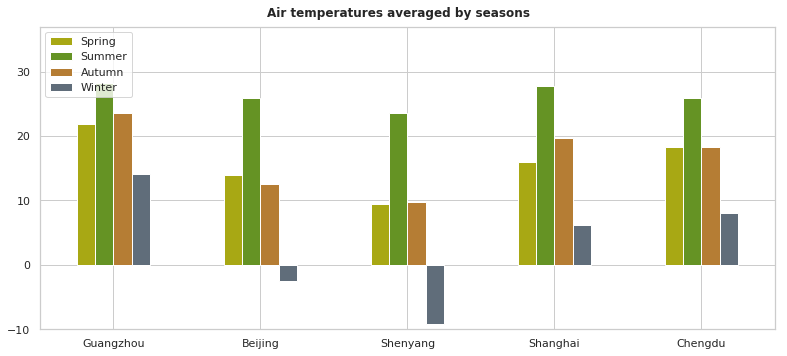

,Guangzhou,Beijing,Shenyang,Shanghai,Chengdu
Spring,21.9,14,9.46,16,18.3
Summer,28.2,25.9,23.6,27.7,26
Autumn,23.6,12.6,9.81,19.8,18.4
Winter,14.1,-2.43,-9.2,6.23,8.05


In [23]:
# Merge all cities into one DataFrame
df = [ 
    df[['Temperature', 'Season']]
    .rename(columns={'Temperature': city})
    for city, df in dfs.items() 
]

# Average by seasons
df = reduce(lambda l, r: l.merge(r, on='Date'), df)\
     .groupby(['Season']) \
     .mean() \
     .filter(regex='^(?!Season)')

df.index = ['Spring', 'Summer', 'Autumn', 'Winter']

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
plt.tight_layout()
fig.subplots_adjust(top=0.925)
fig.suptitle('Air temperatures averaged by seasons')

with sns.color_palette(SEASONS_PALETTE):
    df.transpose().plot(kind='bar', ylim=(-10, 37), ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(list(df.index), loc='upper left');
for tick in ax.get_xticklabels(): tick.set_rotation(0)

plt.show()

lo = df.min().min()
hi = df.max().max()
display(df.style.applymap(color_by_value(lo, hi)))

we note that "dirty" Beijing and Chengdu have much colder winters than "clean" Shanghai and Guangzhou. This may explain the difference in pollution levels: chances are in "clean" cities less fuel is required to be burned for heating, which means that less particulate matter is released. 

#### Remark: Correlation vs causation

Although we have discovered correlation between several phenomena, we draw attention to the fact, that our study does not exposes any causal relations between them. For example, proving the existing of a causality chain between PM<sub>2.5</sub> levels, fuel combustion for heating and cold weather would require more external information and expert judjement about infrastructure, population, fuel types etc.

## Preparing the dataset

In order to make the data suitable for methods sensitive to missing values and for forecasting models, we perform the following manipulations:

 - We take only intervals with relatively stable ranges of contiguous valid observations: between January 2013 and December 2015
 - As an example of simple feature engineering, we convert textual labels of wind directions to angles in radians. We argue that this can provide more domain-specific information to the model, as textual labels of directions, such as "N", "NE" etc. have no clear context of relations between different directions, while angular values have.
 - We compute the daily average values all columns
 - After that, we fill missing values in column "PM US Post" with values from other PM columns
 - After that, we fill the minor gaps in all columns by propagating values forward, then backward, leaving no missing values

In [24]:
# We keep only this PM column, but all non-PM columns
column='PM US Post'

def compass_to_radians(direction, notfound=np.nan):
    """
        Convert compass direction to corresponding angle in radians.
        For example, "N" will be resolved to 0.0, "S" to 3.14 (Pi), "SW" to 3.927 and "Foo" to NaN.
    """
    
    directions = [
        'N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
        'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW' 
    ]
        
    try:
        i = directions.index(direction)
    except ValueError:
        return notfound
        
    return i * 2.0 * np.pi / 16.0


def clean_one_city(df):
    """
        Cleans data for one city
    """
    
    # Convert wind directions to angles in radians
    df['Wind dir'] = df['Wind dir'].map(compass_to_radians)
    
    # Take only a subset of the time range
    df = df['2013':]
    
    # Average daily
    df = df.resample('D').mean()

    # Fill invalid values in chosen PM column 
    # with valid values from other PM columns
    for col in df.filter(like='PM').columns:
        if col == column: continue
        df[column].fillna(df[col], inplace=True)
        df.drop(columns=col, inplace=True)

    # Fill the rest of invalid values (PM and others) 
    # by copying neigbors forward, then backward
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df = df.rename(columns={column: 'PM'})
    
    return df

dfs_clean = { city: clean_one_city(dfs[city].copy()) for city, df in dfs.items() }

count_invalid(dfs_clean)

,Num. NaN,Length
Guangzhou,0,1095
Beijing,0,1095
Shenyang,0,1095
Chengdu,0,1095
Shanghai,0,1095


After preprocessing, we obtain dense sequences, each of length 1095 steps and with constant rate of 1 day⁻¹.

## Stationarity, trend, seasonality

Now that the data is clean, let's analyze stationarity, trend and seasonality of the data in a more formal setting.

We take one of the cities and we decompose the PM<sub>2.5</sub> into trend, seasonal component and noise component assuming that we are looking for annual patterns:

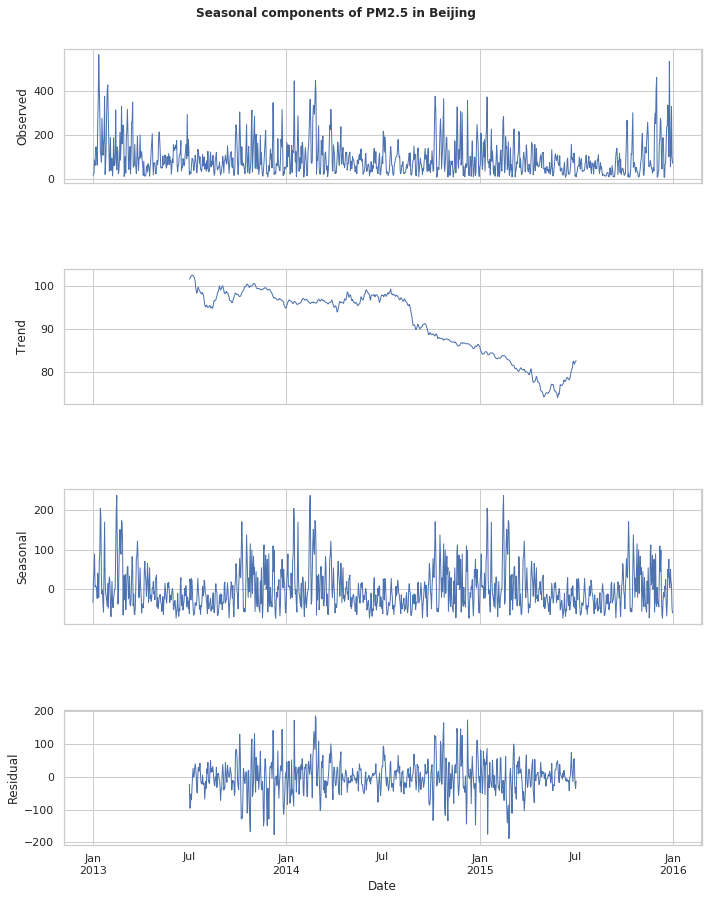

In [25]:
df = dfs_clean['Beijing']['PM']

decomposition = seasonal_decompose(df, model='additive', freq=365)  
fig = decomposition.plot()
fig.set_size_inches(11, 15)
fig.suptitle('Seasonal components of PM2.5 in Beijing');

Decomposition confirms complex noisy and non-stationary nature of the time-series. We notice a subtle downward trend and clear annual seasonality as we discussed previously.

Additionally, if we zoom in on the seasonal component, we can observe a noticable weekly pattern, slightly more pronounced during winter months:

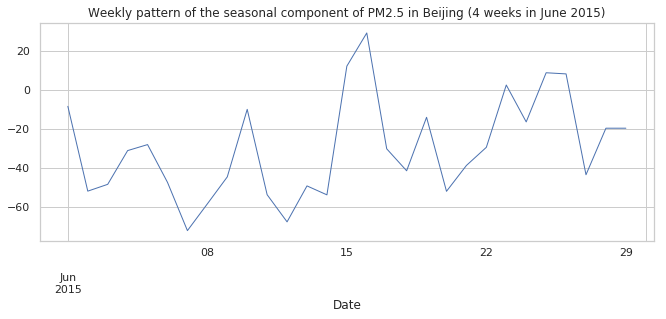

In [26]:
fig = decomposition.seasonal['20150601':'20150629']\
    .plot(figsize=(11, 4), 
          title='Weekly pattern of the seasonal component of PM2.5 in Beijing (4 weeks in June 2015)')

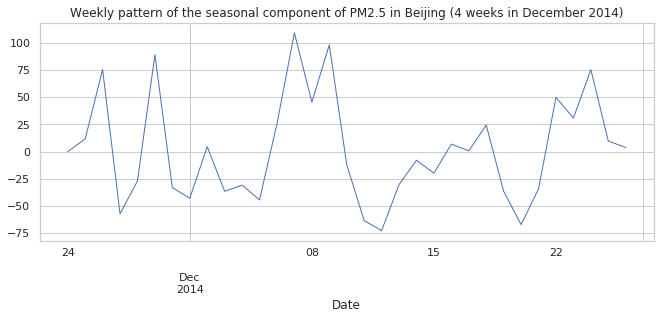

In [27]:
fig = decomposition.seasonal['20141124':'20141226']\
    .plot(figsize=(11, 4), 
          title='Weekly pattern of the seasonal component of PM2.5 in Beijing (4 weeks in December 2014)')

Although we are concentrating on long-term analysis and predictions, in the future it may be worthwile exploring the more finegrained periodicity as well. Weekly fluctuations may be associated with the fact that heavy industries are likely closed on weekends, leading to pollution decrease during these days.

## Autocorrelation

Although the sequences are not stationary, let's inspect the Autocorrelation Function (ACF) for any interesting phenomena. Autocorrelation plot below shows how PM<sub>2.5</sub> time-series correlates with itself shifted by different number of time-steps (lags):

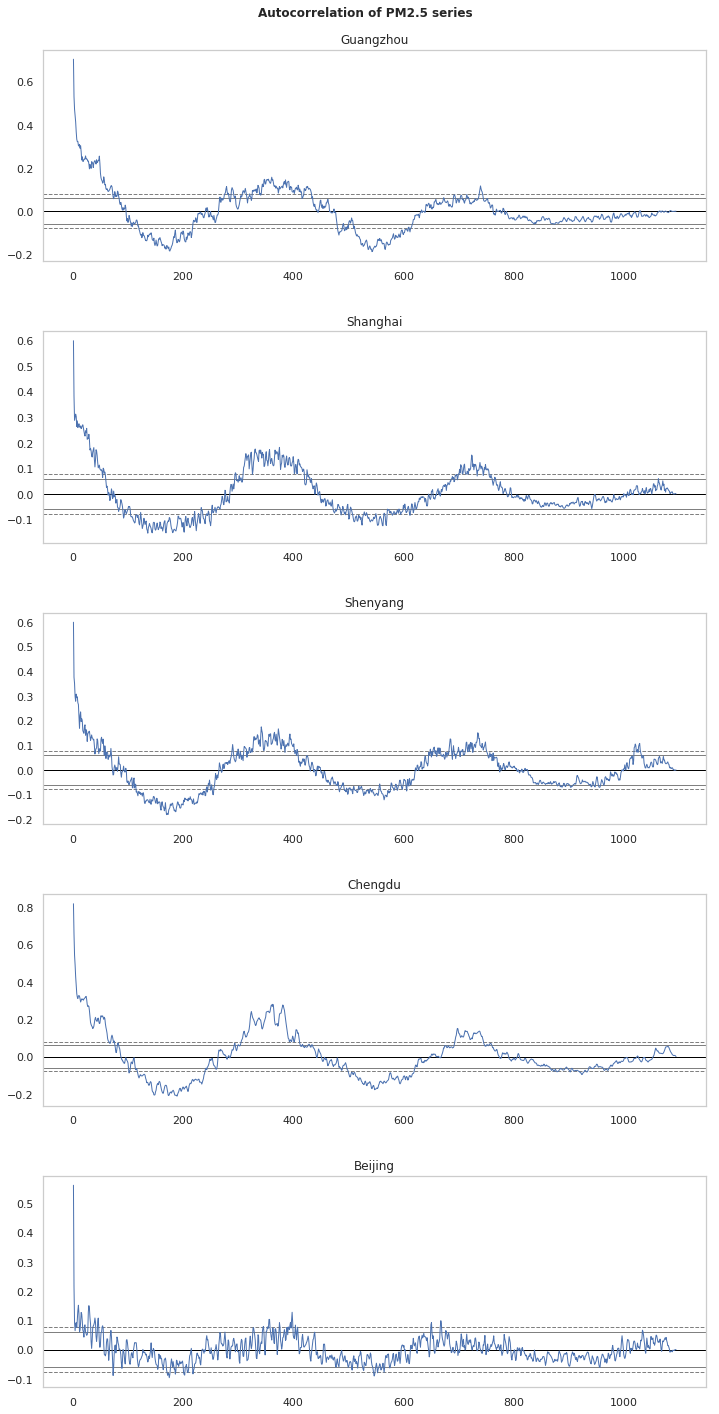

In [28]:
fig, ax = plt.subplots(nrows=len(dfs), ncols=1, figsize=(10,len(dfs) * 4))
plt.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.33)
fig.suptitle('Autocorrelation of PM2.5 series')

for i, (city, df) in enumerate(dfs_clean.items()):
    pd.plotting.autocorrelation_plot(df['PM'], ax=ax[i])
    ax[i].set_title(city)
    prettify_axis(ax[i])

ACF plots hint on seasonality we've studied previously also exposing the period of around 1 year.

## Periodic components

Let's apply fast fourier transform (FFT) to extract frequencies of periodic components of the process.

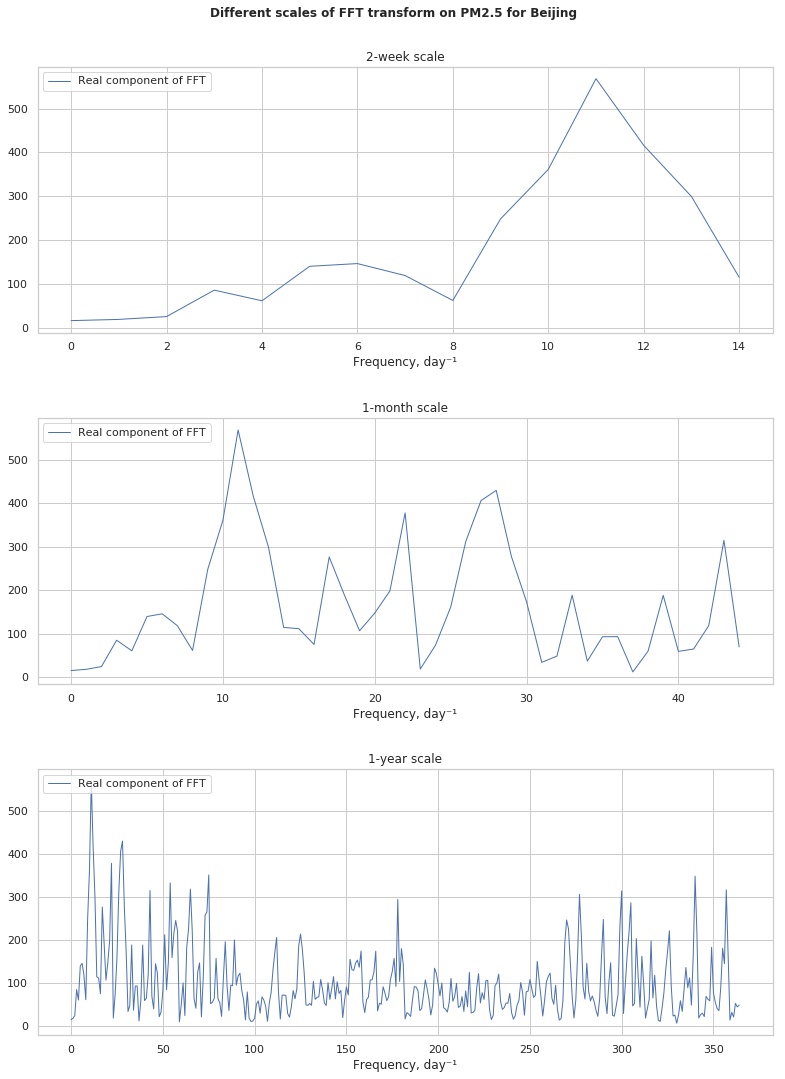

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(11, 15))
plt.tight_layout()
fig.subplots_adjust(top=0.925, hspace=0.32)
fig.suptitle('Different scales of FFT transform on PM2.5 for Beijing ')

def plot_fft_daily(df, scale, ax, title):        
    begin, end = tuple(scale)
    
    t = df.index.day.astype(np.float)
    x = df.values
    
    fft_x = np.real(np.fft.fft(x))[begin:end]  
    freqs = np.arange(begin, end)
    ax.plot(freqs, fft_x)
    ax.set_title(title)
    ax.legend(['Real component of FFT'], loc='upper left');
    ax.set_xlabel('Frequency, day⁻¹')
    
df = dfs_clean['Beijing'][['PM']]

plot_fft_daily(df, scale=(0, 15), ax=axes[0], title='2-week scale')
plot_fft_daily(df, scale=(0, 45), ax=axes[1], title='1-month scale')
plot_fft_daily(df, scale=(0, 365), ax=axes[2], title='1-year scale')

Due to large amount of noise in the data, FFT is not particularly helpful, but we can notice spikes at weekly-biweekly, monthly, semi-annual and annual frequencies. These are the targets for potential investigation. As we mentioned already, pollution is usually associated to human activities and those are tightly related to the calendar events. So the perodicity on multiple time scales is not unexpected here.

## Forecasting of daily PM<sub>2.5</sub>

In this section we attempt to model (forecast) the behavior of daily-averaged PM<sub>2.5</sub> values as previously discussed. 

We imagine that prediction of future daily levels of PM<sub>2.5</sub> is as useful as weather forecasting (or even more so). Indeed, people of China may be interested to know when pollution is expected to rise throughout the next week, next month or next year. 

Therefore, we build the model the same way as if we would for weather forecasting: given an input sequence in a specific time range, our model should output predicted values of PM<sub>2.5</sub> for a given time range in the future. 

We work with cleaned daily data that we've prepared above and will make long-term preditions on monthly-annual scale.

### Experimental setup

#### Data splits

We will be predicting PM<sub>2.5</sub> for 2 cities: Beijing and Chengdu (as an example of a "dirty" and a "clean" city respectively). 

We reserve 20% of datapoints in the end of each sequence for testing (evaluation), while using the rest for training and validation.

In [30]:
# We forecast for these cities
FORECAST_CITIES = ['Beijing', 'Chengdu']

# A portion of data that will be held aside for testing
TEST_RATIO = 0.2

def split(df):
    """
        Split data for one city into two subsets: training and testing
    """
    
    n_total = len(df)
    n_test = int(round(n_total * TEST_RATIO))
    n_train = n_total - n_test
    
    past = df.index[:n_train]
    future = df.index[n_train:]

    train = df.loc[past]
    test = df.loc[future]
    
    return train, test

#### Metrics

We will asses the quality of forecasting, by comparing the predicted values returned by models to ground truth values from the testing set, using following metrics:

 - Mean absolute error (MAE): popular, easily interpretable and intuitive metric for regression models. Obtaned by taking absolute value of difference between predicted values and ground truth. Measured in the same units and scale as original PM<sub>2.5</sub> values (in our case, µg/m³).
 - Root mean sequare error (RMSE): similar to MAE, except that the difference is squared. It "punishes" exagerrated errors more agressively, while still being measured in the same units and scale as original values.

Let's define a function to calculate these:

In [31]:
METRICS = ['MAE', 'RMSE']

def calculate_metrics(preds, truths):
    """
        Calculates evaluation metrics given an array of predicted values
        and an array of ground truth values
    """
    
    # Mean absolute error (MAE)
    mae = sklearn.metrics.mean_absolute_error(y_pred=preds, y_true=truths)
    
    # Root-mean-square error (RMSE)
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_pred=preds, y_true=truths))
    
    return mae, rmse

We can also think of more sophisticated metrics, like string-related metrics that take into account the sequentiality and order of datapoints. There may also exist domain-specific metrics for pollution or weather forecasting that are appropriate for this research.

In this work we decided to keep things simple and to use the most widespread and intuitive error measures.

#### Models

We will discuss, compare and analyze predictions of following models:
 - Linear Regression with Least Squares
 - Seasonal Autoregressive Integrated Moving Average with exogenous regressors (SARIMAX)
 - Naïve persistence model
 
Let's proceed to building and running the models.

In [30]:
# We will gather all the results into this dict
results = OrderedDict()

### Experiments

#### Model 1: Linear Regression with Least Squares

To establish a simple baseline, we will fit a linear function using Least Squares algorithm.

In [33]:
def linear_regression(train, test):

    # Add feaure dimension (1 in our case)
    # and convert dates to unix timestamps (int64)
    x_train = np.expand_dims(train.index, axis=1).astype(np.int64)
    y_train = np.expand_dims(train['PM'].values, axis=1)
    x_test = np.expand_dims(test.index, axis=1).astype(np.int64)
    y_test = np.expand_dims(test['PM'].values, axis=1)

    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    
    # Remove feature dimension
    preds = np.squeeze(preds)

    metrics = calculate_metrics(preds=preds, truths=y_test)
   
    return { 'metrics': metrics, 'preds': preds }

results['Linear regression'] = { 
    city: linear_regression(*split(dfs_clean[city])) 
    for city in FORECAST_CITIES
}

metrics = pd.DataFrame.from_dict({
    city: results['Linear regression'][city]['metrics']
    for city in FORECAST_CITIES
}).transpose()\
.rename(columns={ i: m for i, m in enumerate(METRICS)})

metrics.loc['Average'] = [ metrics[m].mean() for m in METRICS ]
results['Linear regression']['Average'] = metrics.loc['Average']

metrics

,MAE,RMSE
Beijing,56.813,84.724
Chengdu,27.814,38.950
Average,42.313,61.837


Obtained error metrics are very high, reaching the average scale of PM<sub>2.5</sub> values themselves. It is somewhat expected for a simple model. Our goal now is to ensure that the more complex models perform better.

Let's take a minute and analyze the predictions:

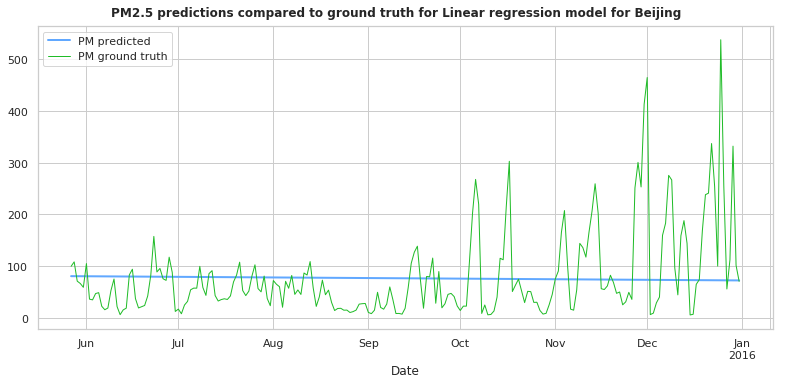

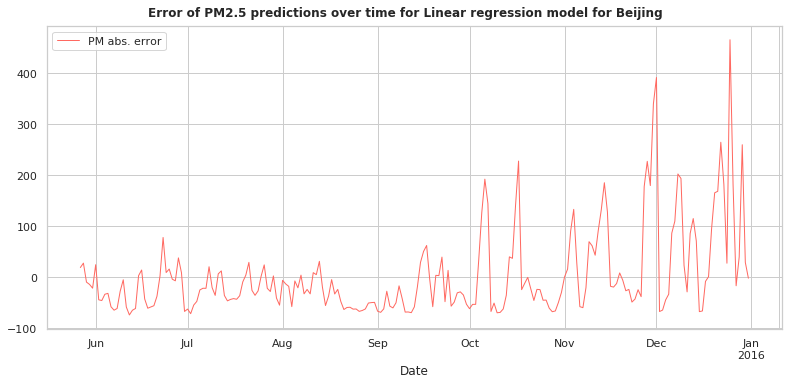

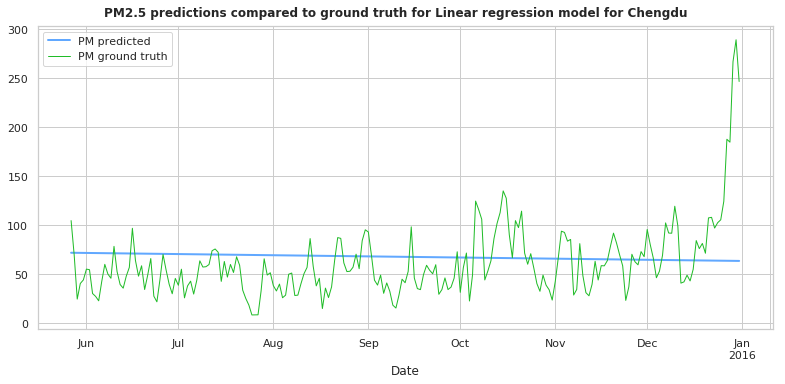

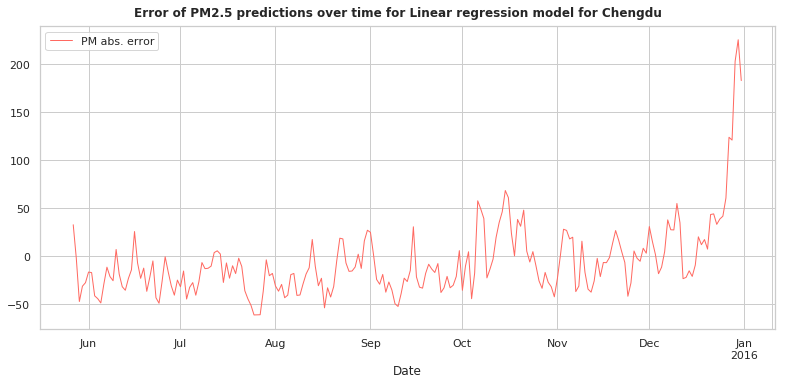

In [34]:
def plot_results(results, model_name):
    for city in FORECAST_CITIES:
        train, test = split(dfs_clean[city])

        preds = results[model_name][city]['preds']

        df_preds = pd.DataFrame.from_dict(
            { 'PM': preds, 'Date' : test.index }) \
            .set_index('Date') 

        df_test = test[['PM']]

        df_error = df_test - df_preds

        with sns.color_palette(['#61a8ff', '#20bc28']):
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
            plt.tight_layout()
            fig.subplots_adjust(top=0.925)
            fig.suptitle('PM2.5 predictions compared to ground truth for {} model '
                         'for {}'.format(model_name, city))

            df_preds.rename(columns={'PM': 'PM predicted'}).plot(ax=ax, linewidth=2)
            df_test.rename(columns={'PM': 'PM ground truth'}).plot(ax=ax)

        with sns.color_palette(['#ff6961']):
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))
            plt.tight_layout()
            fig.subplots_adjust(top=0.925)
            fig.suptitle('Error of PM2.5 predictions over time for {} model '
                         'for {}'.format(model_name, city))   
            df_error.rename(columns={'PM': 'PM abs. error'}).plot(ax=ax)
        
    plt.show()
    
plot_results(results, 'Linear regression')

Obtained line is almost horizontal, making predictions almost constant, with slight decreasing trend, probably captured from the overall decrease in pollution over years in training data. In this case, it is obvious that this model will not be able to describe the seasonal fluctuations. In fact, it predicted that the values in December will be lower than in July, which we know is strictly false (and obfuscates a serious problem of winter overpollution).

This makes Linear regression a good baseline, but practically applicable only very narrowly, for very long-term predictions (on a scale of decades and centuries) for non-critical applications. For short-term analysis and decision-making, especially considering important environmental problems and health of the population, more sophisticated models should be used.

#### Model 2: Seasonal Autoregressive Integrated Moving Average with exogenous regressors (SARIMAX)

Autoregressive Integrated Moving Average (ARIMA) is a family of regressors that combine Autoregressive model (AR), Moving Average model (MA) and integration/detrending. SARIMAX is an advanced version of ARIMA that can work with seasonal data and can also accept exogenous variables, additionaly to the predicted ones. This family of models is a popular choice for time-series forecasting.

SARIMAX has the two sets of parameters, called "orders". These can be intuitively understood as "strengths" of corresponding components of the model:

 - $(p, d, q)$ is an "oder" of non-seasonal part of the model. The values define coefficitns for Autoregressive, Integrated and Moving Average parts (in that order) of of non-seasonal part
 - $(P, D, Q, s)$ is an "oder" of seasonal part of the model. Similarly, the values define coefficitns for Autoregressive, Integrated and Moving Average parts. The parameter $s$ defines a period.
 
As exogenous data we provide columns "Season" and "Temperature", because, as we learned, these columns are related to PM<sub>2.5</sub> values. This might improve the accuracy of predictions (but comparative study would be preferable, of course). Note that we also have to provide the exogenous variables on test time. This meas that we assume the weather data or its forecast is available for future time steps.

We perform a limited (due to time/performance reasons) search of parameters for SARIMAX and then select a model that yield the best MAE.

,MAE,RMSE
Beijing,52.7,78
Chengdu,23.1,33.6
Average,37.9,55.8


,p,d,q,P,D,Q,s
Params,0,0,0,1,0,1,12


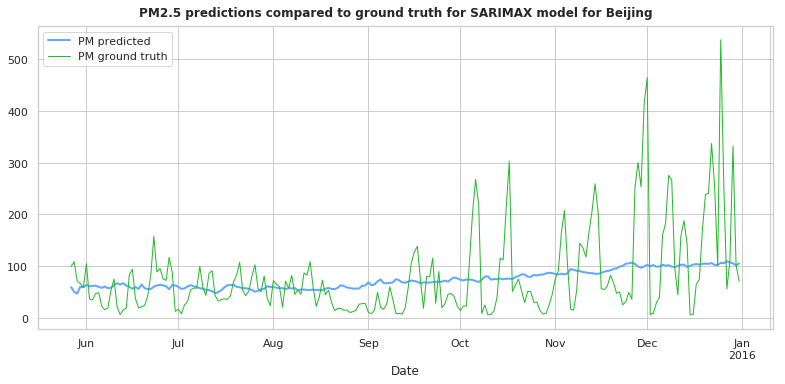

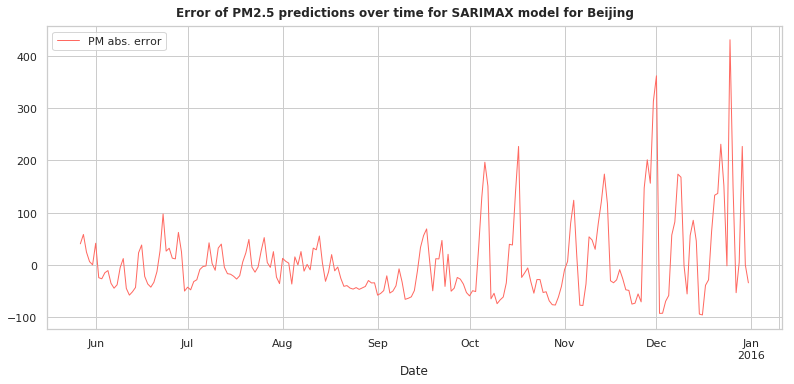

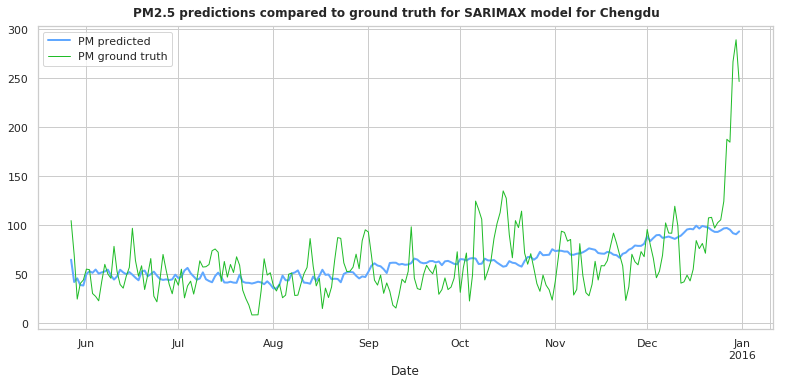

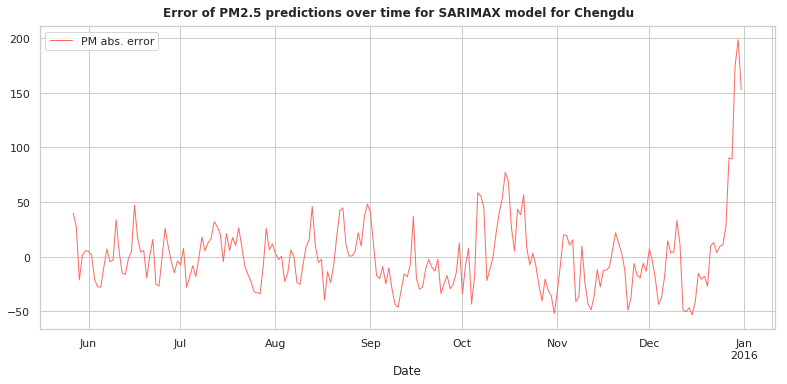

In [35]:
def sarimax(df, params):
    p, d, q = params.p, params.d, params.q
    P, D, Q, s = params.P, params.D, params.Q, params.s
    
    train, test = split(df)

    try:

        with warnings.catch_warnings():

            warnings.simplefilter("ignore")

            model = SARIMAX(
                endog=train[['PM']],
                exog=train[['Season', 'Temperature']], 
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                trend='ct'
            )

            model = model.fit(disp=False, maxiter=100)

            preds = model.forecast(len(test), exog=test[['Season', 'Temperature']])

            metrics = calculate_metrics(preds=preds, truths=test['PM'].values)
            
            return { 'metrics': metrics, 'preds': preds }
    except:
        # Ignore invalid orders
        return
        

# Grid search (in reality it should include much wider ranges).
# For SARIMA it can also be much smarter and faster than this bruteforce.
parameters = OrderedDict([
    # Order
    ( 'p', range(0, 3) ),     # autoregression
    ( 'd' , range(0, 1) ),    # differences
    ( 'q' , range(0, 3) ),    # moving average
    
    
    # Seasonality order (same as order + seasonality frequency)
    ( 'P', range(0, 3) ),     # autoregression
    ( 'D' , range(0, 1) ),    # differences
    ( 'Q' , range(0, 3) ),    # moving average
    ( 's' , [12] ),           # yearly seasonality
])

grid = ParameterGrid(parameters)


sarimax_params = []
sarimax_metrics = []
sarimax_results = []
for params in grid:
    sarimax_params.append(params)
    
    param_names = list(parameters.keys())
    params = dict_to_namedtuple(params)

    # Predict for each city
    result = { city: sarimax(dfs_clean[city], params) for city in FORECAST_CITIES }

    # Ignore invalid orders
    if None in result.values():
        continue
    
    # Gather metrics
    metrics = pd.DataFrame.from_dict({
        city: result[city]['metrics']
        for city in FORECAST_CITIES
    }).transpose().rename(columns={ i: m for i, m in enumerate(METRICS)})
    
    # Calculate an average of metrics
    avg = [ metrics[m].mean() for m in METRICS ]
    metrics.loc['Average'] = avg    
    
    sarimax_metrics.append(metrics)
    sarimax_results.append(result)

# Identify the model with the best MAE
idx_best_mae = np.argmin([ m.loc['Average']['MAE'] for m in sarimax_metrics ])

# Display best metrics
sarimax_metrics_best = sarimax_metrics[idx_best_mae]
display(sarimax_metrics_best.style.set_caption('Metrics of the best SARIMAX model'))

# Display best parameters
display(pd.DataFrame.from_dict(sarimax_params[idx_best_mae], orient='index', columns=['Params'])\
.transpose()[list(parameters.keys())].style.set_caption('Parameters of the best SARIMAX model'))

results['SARIMAX'] = sarimax_results[idx_best_mae]
results['SARIMAX']['Average'] = sarimax_metrics_best.loc['Average']

plot_results(results, 'SARIMAX')

SARIMAX demonstrates an improvement over Linear regression. It has been able to correctly model both, the overall trend and major seasonal variations, including winter grow. However, it provided a smooth curve, which does not reflect the erratic behavior of PM<sub>2.5</sub> values. It was unable to model the fine-grained fluctuations and significantly underestimated autumn-winter spikes.

#### Model 3: Naïve Persistence model

Our exploratory analysis has shown that the data has periodical properties on multiple time scales.
We build a simple custom model to exploit these properties explicitly. It works as follows: to make a prediction $y_t$ for time point $ t $ in the future, we take a datapoint $x_{t-l}$ from the past, with a temporal distance of $l$ from $t$, scale it by a constant factor $s$ and add a constant bias $c$:
 
\begin{align}
y_t = s x_{t-l} + c
\end{align}

We call $s$ the "scale", $c$ the "constant", and $l$ the "lag".

Sometimes this kind of models is called "persistence models" for their ability to remember and naïvely copy the values from the past data.

Again, we perform parameter search for scale, constant and lag and choose the best performing parameter set as measured by MAE.

,MAE,RMSE
Beijing,51.8,85.3
Chengdu,22.2,33.7
Average,37,59.5


,lag,scale,constant
Params,360,0.25,40


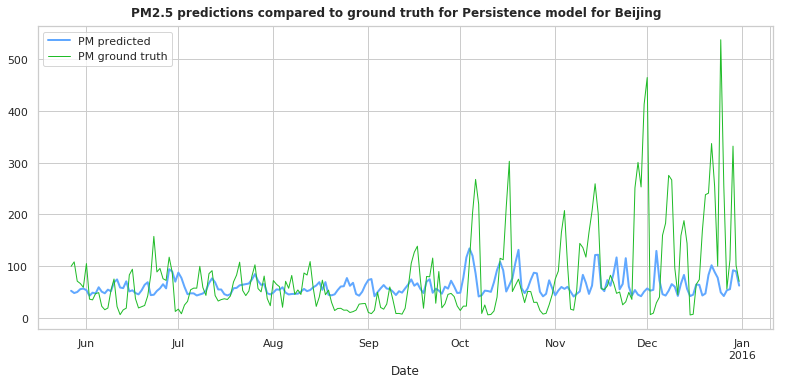

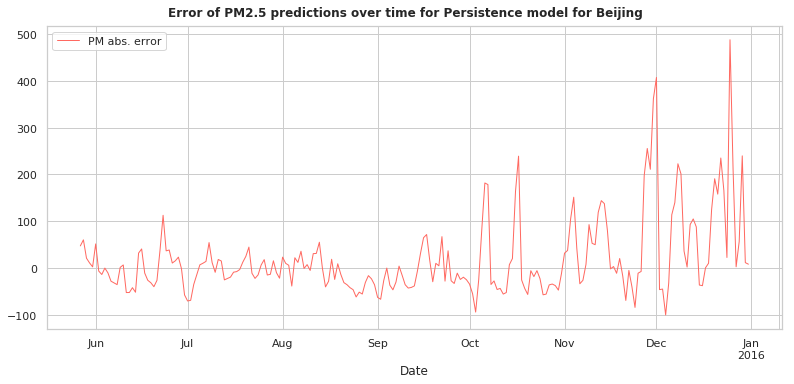

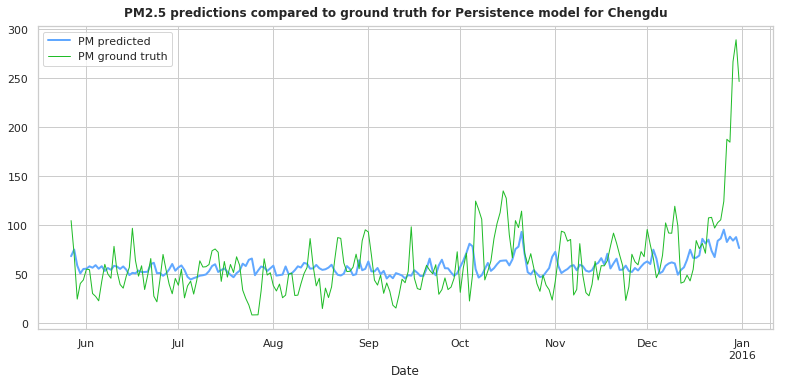

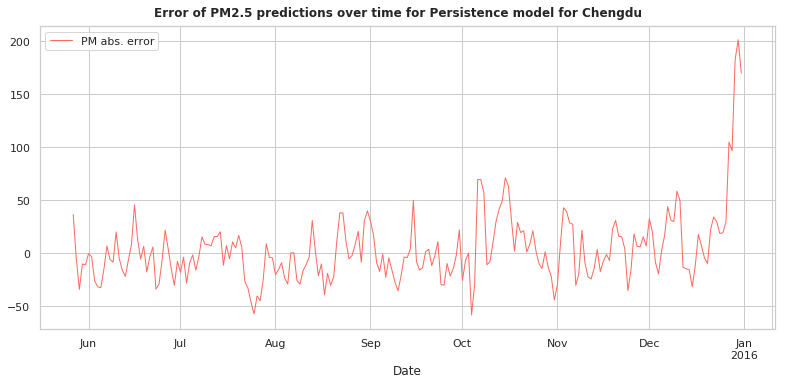

In [36]:
def naive_persistence_model(df, params):
    """
        Naive Persistence model for sequence forecasting.
        
        Predicts future datapoins from the past ones. 
        Predictions are obtained by going back by a given time lag, 
        then scaling by a given ratio and shifting by a given constant factor
    """
    
    train, test = split(df)

    begin = len(train) - params.lag
    end = begin + len(test)
    
    preds = (params.scale * train[begin:end] + params.constant)['PM'].values
    
    metrics = calculate_metrics(preds=preds, truths=test['PM'].values)    
 
    mae, rmse = metrics
    if 0 == mae:
        print(preds)
    
    return { 'metrics': metrics, 'preds': preds }

train, test = split(df)

# Lag from 'size of the testing set' to 2+ years
min_lag = len(test)
max_lag = DAYS_IN_YEAR * 2 + DAYS_IN_WEEK

parameters = OrderedDict([
    ('lag', range(min_lag, max_lag)),
    ('scale', [0.250, 0.333, 0.500, 1.000, 1.25, 1.33]),
    ('constant', range(-50, +50, 10))
])

grid = ParameterGrid(parameters)

persist_params = []
persist_metrics = []
persist_results = []
for params in grid:
    persist_params.append(params)
    
    param_names = list(parameters.keys())
    params = dict_to_namedtuple(params)

    # Predict for each city
    result = {
        city: naive_persistence_model(dfs_clean[city], params) 
        for city in FORECAST_CITIES 
    }
   
    # Gather metrics
    metrics = pd.DataFrame.from_dict({
        city: result[city]['metrics']
        for city in FORECAST_CITIES
    }).transpose().rename(columns={ i: m for i, m in enumerate(METRICS)})
       
    # Calculate an average of metrics
    avg = [ metrics[m].mean() for m in METRICS ]
    metrics.loc['Average'] = avg    
    
    persist_metrics.append(metrics)
    persist_results.append(result)

# Identify the model with the best MAE
idx_best_mae = np.argmin([ m.loc['Average']['MAE'] for m in persist_metrics ])

# Display best metrics
persist_metrics_best = persist_metrics[idx_best_mae]
display(persist_metrics_best.style.set_caption('Metrics of the best Persistence model'))

# Display best parameters
display(pd.DataFrame.from_dict(persist_params[idx_best_mae], orient='index', columns=['Params'])\
.transpose()[list(parameters.keys())].style.set_caption('Parameters of the best Persistence model'))

results['Persistence'] = persist_results[idx_best_mae]
results['Persistence']['Average'] = persist_metrics_best.loc['Average']

plot_results(results, 'Persistence')

Persistence model although very simple is developed with exploting data repetivity in mind, shows overall good results. It is much more expressive in terms of short-term fluctuations, imitating ("copying") them from the past. Linear transformation that we apply also seem to be helping to compensate for the trend.

Interestingly, the best parameters include lag of 360 days. Meaning that the best prediction is obtained from roughly the same day of the preceeding year.

### Results summary

Let's summarize the results of all our experiments in a table:

In [37]:
pd.DataFrame.from_dict(
    { mod: res['Average'] for mod, res in results.items() }            
).transpose().loc[list(results.keys())].style.apply(highlight_column(METRICS))

,MAE,RMSE
Linear regression,42.3,61.8
SARIMAX,37.9,55.8
Persistence,37,59.5


Persistence and SARIMAX models perform very similarly, with Linear regression model following close behind. 

To be fair, we only explored a narrow range of parameters for SARIMAX and significantly better results may (or may not) be obtained after a more thorough parameter search.

One may notice that the error metrics for Beijing are twice as higher than such for Chengdu. This may tell us that the PM<sub>2.5</sub> behavior in "dirty" cities is harder to predict, probably due to more prononced noisy residual component. But to draw a conclusion more research is required here, in particular one may try to fit these models for the rest of cities and compare the results.

## Conclusion

In this work we briefly explored the levels for PM<sub>2.5</sub> particular matter pollution in five major Chinese cities. We tried to analyze and forecast these values.

The data is characterised by temporal patterns on multiple scales. Some measurement errors and missing values were found. Analysis reveals clear seasonality of PM<sub>2.5</sub> pollution with significant increase during cold periods and decrease during summer, as well as periodic changes thoughout weekdays. Air quality vary signifcantly between cities.

Overall, simple models that we have tried have shown theoretically interesting but practically unsatisfactory results. It may mean that, for practical purposes, more sophisticated models (such as gradient boosing and recurrent neural networks, popular nowadays) should be explored. These models, having more expressive power, may provide more reliable predictions, however would probably require more data (more sequences from more cities) to show  their best.

We hope that as more datasets and their scientific analyses are becoming available publicly, the problems of pollution will eventually be drawing more attention of governments and influential organizations, making them focus more on preserving of the ecosystem of our planet and the improvement of health and quality of life of the the population.

## References

\[1\] US Code of Federal Regulations. Title 40 - Protection of Environment. URL: https://www.gpo.gov/fdsys/pkg/CFR-2017-title40-vol2/xml/CFR-2017-title40-vol2-sec50-18.xml

\[2\] China: Air Quality Standards. English source: TransportPolicy.net. URL: https://www.transportpolicy.net/standard/china-air-quality-standards/

\[3\] European Comissions' Air Quality Standards. URL: http://ec.europa.eu/environment/air/quality/standards.htm

\[4\] PM<sub>2.5</sub> Data of Five Chinese Cities. Machine Learning Repository of the University of California, Irvine. URL: https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities

\[5\] Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10,220–10,236, doi: 10.1002/2016JD024877

\[6\] Wikipedia: July 2012 Beijing flood. URL: https://en.wikipedia.org/wiki/July_2012_Beijing_flood